<div align="center">
  
### ALGORITHMIC PROGRAMMING: ORDER ACCEPTANCE AND SCHEDULING PROBLEM 

</div>


<div align="center">

### Students: Vivens Irakoze, Ioannis Villis

</div>


---

### Overview

This Notebook covers the implementation of exact solutions, greedy heuristics, and local search improvement heuristics for various instances provided for project.

#### Chapter 1

The *readinput* function processes all provided instances, extracting duration, profit, due date, deadline, tardiness cost, setup time for each order, and the number of orders.

#### Chapter 2

This section includes helper functions to streamline calculations, such as profit evaluation, feasibility checks, start/end times, and schedule visualization to avoid redundant computations at each stage.

#### Chapter 3

Brute-force and Mixed Integer Programming (MIP) solutions were implemented for the first two files due to exponential runtime growth with increased orders. These methods were executed within a few minutes for small datasets.

#### Chapter 4

Greedy heuristics, including insertion, savings, and construction methods, are implemented with visualizations for analysis.

#### Chapter 5

Local search improvement heuristics are introduced, starting from basic solutions generated through construction heuristics. Additionally, move heuristics are explored using both first-accept and best-accept strategies.

#### Chapter 6

Comparison studies are conducted to evaluate and visualize the performance Exact solutions and of all heuristics, focusing on runtime and total profit outcomes.

---



### 1. Input Data

- ***Read Input Data:***

In [3]:
import numpy as np
import time

file_names = ['OAS0.txt', 'OAS1.txt', 'OAS2.txt', 'OAS3.txt', 'OAS4.txt', 'OAS5.txt', 'OAS6.txt']

def readInput(fileName):
    """
    Read the input data from a file and return relevant arrays.
    """
    file0 = open(fileName, 'r')

    data = np.loadtxt(fileName)

    duration = data[0].astype(int) 
    profit = data[1].astype(int) 
    dueDate = data[2].astype(int) 
    deadline = data[3].astype(int)  
    tardCost = data[4] 
    numberOrders = len(duration) 

    setup = np.zeros((numberOrders, numberOrders)).astype(int) 
    index = 0
    while index < numberOrders:
        setup[index] = data[5 + index].astype(int)
        index += 1

    file0.close()

    return duration, profit, dueDate, deadline, tardCost, numberOrders, setup

### 2. Helper Functions

In [4]:
from itertools import permutations
import matplotlib.pyplot as plt

'''1.Start Times Calculation'''
def cal(duration, setup, sequence):
    # Calculate start and finish times for a given sequence.
    num_orders = len(sequence)
    start_times = np.zeros(num_orders)
    finish_times = np.zeros(num_orders)

    # Initial order
    start_times[0] = 0
    finish_times[0] = duration[sequence[0]]

    # Compute times for subsequent orders
    for i in range(1, num_orders):
        prev_order = sequence[i - 1]
        current_order = sequence[i]
        start_times[i] = finish_times[i - 1] + setup[prev_order][current_order]
        finish_times[i] = start_times[i] + duration[current_order]

    return start_times, finish_times


'''2.Feasibility Check and Profit Calculation'''

def eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence):
    # Evaluate a given sequence for feasibility and objective value.
    num_orders = len(sequence)
    start_times = np.zeros(num_orders)
    finish_times = np.zeros(num_orders)
    infeasible = False

    start_times[0] = 0
    finish_times[0] = duration[sequence[0]]

    for i in range(1, num_orders):
        prev_order = sequence[i - 1]
        current_order = sequence[i]
        start_times[i] = finish_times[i - 1] + setup[prev_order][current_order]
        finish_times[i] = start_times[i] + duration[current_order]

    total_profit = 0
    total_tardiness_cost = 0

    for idx, order in enumerate(sequence):
        # Overlapping tasks
        if idx > 0 and start_times[idx] < finish_times[idx - 1]:
            infeasible = True
            return None 

        # Deadline exceeded
        if finish_times[idx] > deadline[order]:
            infeasible = True   
            return None 

        # Profit or tardiness calculation
        if finish_times[idx] <= dueDate[order]:
            total_profit += profit[order]
        else:
            tardiness = finish_times[idx] - dueDate[order]
            total_tardiness_cost += tardiness * tardCost[order]

    if infeasible:
        print("There is no feasible solution.")

    return total_profit - total_tardiness_cost

"""3.Visualization function"""

def visualize(duration, setup, deadline, scheduled_orders, heuristic_name):
    # Function to visualize the schedule using a Gantt chart for a specific heuristic.
    if not scheduled_orders:
        print(f"No scheduled orders to visualize for {heuristic_name}.")
        return

    num_orders = len(scheduled_orders)
    start_times = [0] * num_orders
    finish_times = [0] * num_orders

    for i, order in enumerate(scheduled_orders):
        if i == 0:
            start_times[i] = 0
        else:
            prev_order = scheduled_orders[i - 1]
            start_times[i] = finish_times[i - 1] + setup[prev_order][order]
        finish_times[i] = start_times[i] + duration[order]

    plt.figure(figsize=(12, 8))
    order_color = 'skyblue' 

    for i, order in enumerate(scheduled_orders):
        plt.barh(i, finish_times[i] - start_times[i], left=start_times[i], color=order_color)
        plt.text(start_times[i] + (finish_times[i] - start_times[i]) / 2, i,
                 f"Order {order + 1}", ha='center', va='center', fontsize=10, color='black')
        
        plt.vlines(deadline[order], i - 0.4, i + 0.4, color='red', linestyle='--', label='Deadline' if i == 0 else "")

    plt.yticks(range(num_orders), [f"Order {order + 1}" for order in scheduled_orders])
    plt.xlabel("Time")
    plt.ylabel("Orders")
    plt.title(f"Gantt Chart: {heuristic_name}")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

"""4.Print Function"""

def print_results(file_name, scheduled_orders, total_profit, elapsed_time, heuristic_name):

    scheduled_orders_ = [order + 1 for order in scheduled_orders]
    print(f"Results for {file_name} using {heuristic_name}:")
    print(f"Scheduled Orders: {scheduled_orders_}")
    print(f"Total Profit: {total_profit}")
    print(f"Run Time: {elapsed_time:.4f} seconds")
    print("-" * 50)

"""5.Run, Print and Visualize"""

def Run_and_visualize(file_name, heuristic_function, heuristic_name):

    start_time = time.time() 
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)
    scheduled_orders, total_profit = heuristic_function(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)
    end_time = time.time() 
    elapsed_time = end_time - start_time

    visualize(duration, setup, deadline, scheduled_orders, heuristic_name)

    print_results(file_name, scheduled_orders, total_profit, elapsed_time, heuristic_name)

### 3. Exact Solution Methods

#### **3.1 Brute Force**

- ***Code :***

In [5]:
class Brute_Force_Schedule:
    def __init__(self, duration, profit, dueDate, deadline, tardCost, setup, start_times):
        self.duration = duration
        self.profit = profit
        self.dueDate = dueDate
        self.deadline = deadline
        self.tardCost = tardCost
        self.start_times = start_times  # not really used, just to call eval
        self.setup = setup

    def enumerate_solutions(self):
        """Enumerate all possible solutions using Permutations."""
        best_profit = -float('inf')
        best_sequence = None
        best_finish_times = None

        num_orders = len(self.duration)
        all_solutions = []

        # Iterate through all possible sequences of orders
        for r in range(1, num_orders + 1):  # Include partial solutions with 1 to num_orders orders
            for seq_index, sequence in enumerate(permutations(range(num_orders), r)):
                result = eval(
                    self.duration,
                    self.profit,
                    self.dueDate,
                    self.deadline,
                    self.tardCost,
                    self.setup,
                    self.start_times,
                    sequence,
                )
                if result is not None:
                    all_solutions.append((sequence, result))

                    # Update the best solution if needed
                    if result > best_profit:
                        best_profit = result
                        best_sequence = tuple(order + 1 for order in sequence)  # Convert sequence to 1-based
                        _, best_finish_times = cal(self.duration, self.setup, sequence)

        return best_profit, best_sequence, best_finish_times

- ***Visualization :***

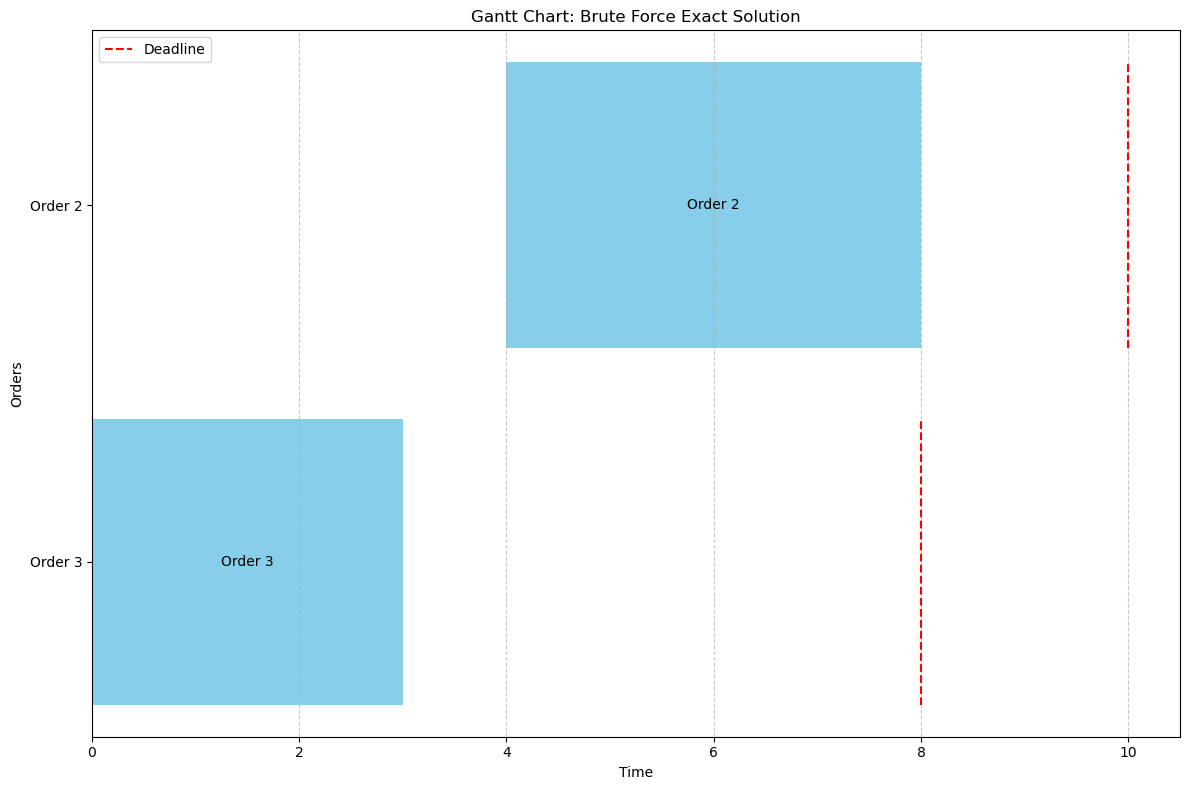

Results for OAS0.txt using Brute Force:
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0190 seconds
--------------------------------------------------


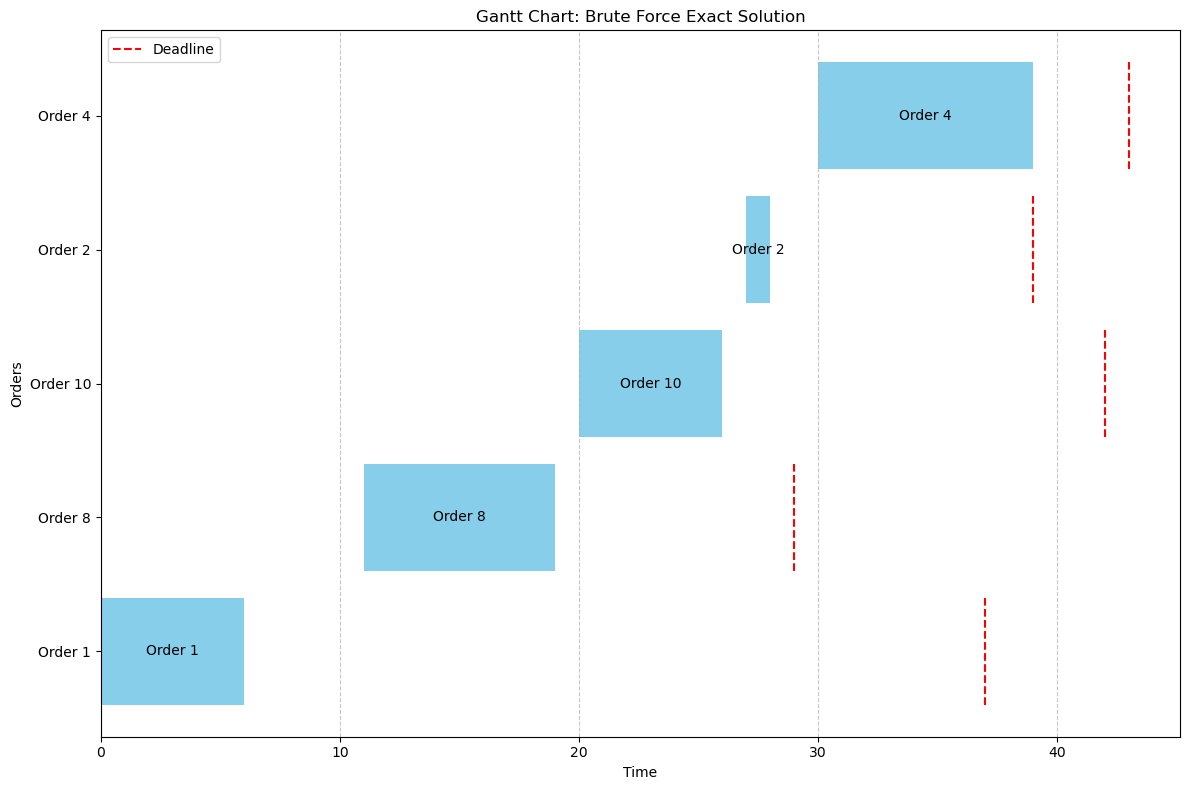

Results for OAS1.txt using Brute Force:
Scheduled Orders: [1, 8, 10, 2, 4]
Total Profit: 382
Run Time: 345.5272 seconds
--------------------------------------------------


In [6]:
def Run_and_visualize_brute_force(file_name):
    start_time = time.time()

    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)

    scheduler = Brute_Force_Schedule(duration, profit, dueDate, deadline, tardCost, setup, start_times=None)
    best_profit, best_sequence, _ = scheduler.enumerate_solutions()

    end_time = time.time()
    elapsed_time = end_time - start_time

    if best_sequence is not None:
        visualize(duration, setup, deadline, [order - 1 for order in best_sequence], "Brute Force Exact Solution")
    else:
        print(f"No feasible solution found for {file_name}.")
        return

    print_results(file_name, [order - 1 for order in best_sequence], best_profit, elapsed_time, "Brute Force")

'''Only the first two files are relevant'''
selected_files = file_names[:2]

for file_name in selected_files:
    Run_and_visualize_brute_force(file_name)

#### **3.2 MIP**

- ***Code :***

In [7]:
def MIP(file_names):
    import gurobipy as gp
    from gurobipy import GRB
    import numpy as np

    # Read input data
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_names)

    # Adding setup times and durations for the dummy start (0) and end (n+1) nodes
    setup_expanded = np.zeros((numberOrders + 2, numberOrders + 2)).astype(int)
    duration_expanded = np.zeros(numberOrders + 2).astype(int)

    setup_expanded[1:numberOrders + 1, 1:numberOrders + 1] = setup
    duration_expanded[1:numberOrders + 1] = duration

    # Create the Gurobi model
    model = gp.Model("MIP_Scheduling")

    # Decision variables
    x = model.addVars(numberOrders + 2, numberOrders + 2, vtype=GRB.BINARY, name="x")  # Does order i precede order j
    y = model.addVars(numberOrders + 2, vtype=GRB.BINARY, name="y")                    # Is order i scheduled?
    f = model.addVars(numberOrders + 2, vtype=GRB.CONTINUOUS, name="f")                # Finish times
    T = model.addVars(numberOrders + 2, vtype=GRB.CONTINUOUS, name="T")                # Tardiness

    # Large constant for big-M constraints
    M = 1000

    # Objective Function
    model.setObjective(
        gp.quicksum(profit[i - 1] * y[i] for i in range(1, numberOrders + 1)) -
        gp.quicksum(tardCost[i - 1] * T[i] for i in range(1, numberOrders + 1)),
        GRB.MAXIMIZE
    )

    # Constraints
    for i in range(numberOrders + 1):  # including dummy start node
        model.addConstr(
            gp.quicksum(x[i, j] for j in range(1, numberOrders + 2) if i != j) == y[i],
            name=f"successor_{i}"
        )
    for i in range(numberOrders + 2):
        model.addConstr(x[i, i] == 0, name=f"no_self_precedence_{i}")
    for i in range(1, numberOrders + 2):  # including dummy end node
        model.addConstr(
            gp.quicksum(x[j, i] for j in range(numberOrders + 1) if i != j) == y[i],
            name=f"predecessor_{i}"
        )
    for i in range(numberOrders + 1):
        for j in range(1, numberOrders + 2):
            if i != j:
                model.addConstr(
                    f[i] + (setup_expanded[i, j] + duration_expanded[j]) * x[i, j] - M * (1 - x[i, j]) <= f[j],
                    name=f"seq_{i}_{j}"
                )
    for i in range(1, numberOrders + 1):
        model.addConstr(f[i] <= deadline[i - 1] * y[i], name=f"deadline_{i}")
    for i in range(1, numberOrders + 1):
        model.addConstr(T[i] >= f[i] - dueDate[i - 1] - M * (1 - y[i]), name=f"tardiness_{i}")
        model.addConstr(T[i] >= 0, name=f"tard_0_{i}")
        model.addConstr(T[i] <= M * y[i], name=f"tard_limit_{i}")

    # Solve the model
    model.optimize()

    # Extract and print results
    if model.status == GRB.OPTIMAL:
        print("Optimal solution found.")
        print("Profit (Objective Value): {:.2f}".format(model.objVal))
        print("\nScheduled Orders:")
        for i in range(1, numberOrders + 1):  # Excluding dummy start and end nodes
            if y[i].x > 0.5:
                print(f"  Order {i}: Finish Time = {f[i].x:.2f}, Tardiness = {T[i].x:.2f}")
    else:
        print("No optimal solution found.")

- ***Visualize :***

In [8]:
def Run_mip(file_names):
    selected_files = file_names[:2]  # Selecting the first two files
    for file_name in selected_files:
        MIP(file_name)

Run_mip(file_names)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2560044
Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 38 rows, 40 columns and 102 nonzeros
Model fingerprint: 0xc1345b4b
Variable types: 10 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 14 rows and 21 columns
Presolve time: 0.03s
Presolved: 24 rows, 19 columns, 81 nonzeros
Variable types: 6 continuous, 13 inte

### 4 Greedy construction heuristics

#### **4.1 Insertion Heuristic**

- ***Code :***

In [9]:
def insertion(duration, profit, dueDate, deadline, tardCost, numberOrders, setup):
    """
    Adds the order that maximizes profit.
    """
    remaining_orders = list(range(numberOrders))  
    scheduled_orders = []  
    total_profit = 0  

    while remaining_orders:
        best_order = None
        best_profit = total_profit

        # Evaluating each remaining order for sequential addition
        for order in remaining_orders:
            # Create a potential schedule by appending an order.
            potential_schedule = scheduled_orders + [order]

            start_times, _ = cal(duration, setup, potential_schedule)
            current_profit = eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, potential_schedule)

            # Update the best order if it improves the profit
            if current_profit is not None and current_profit > best_profit:
                best_order = order
                best_profit = current_profit

        # the best order found is added to the definitive schedule
        if best_order is not None:
            scheduled_orders.append(best_order)
            total_profit = best_profit
            remaining_orders.remove(best_order)
        else:
            # If no feasible order can be added, stop
            break

    return scheduled_orders, total_profit

- ***Visualization :***

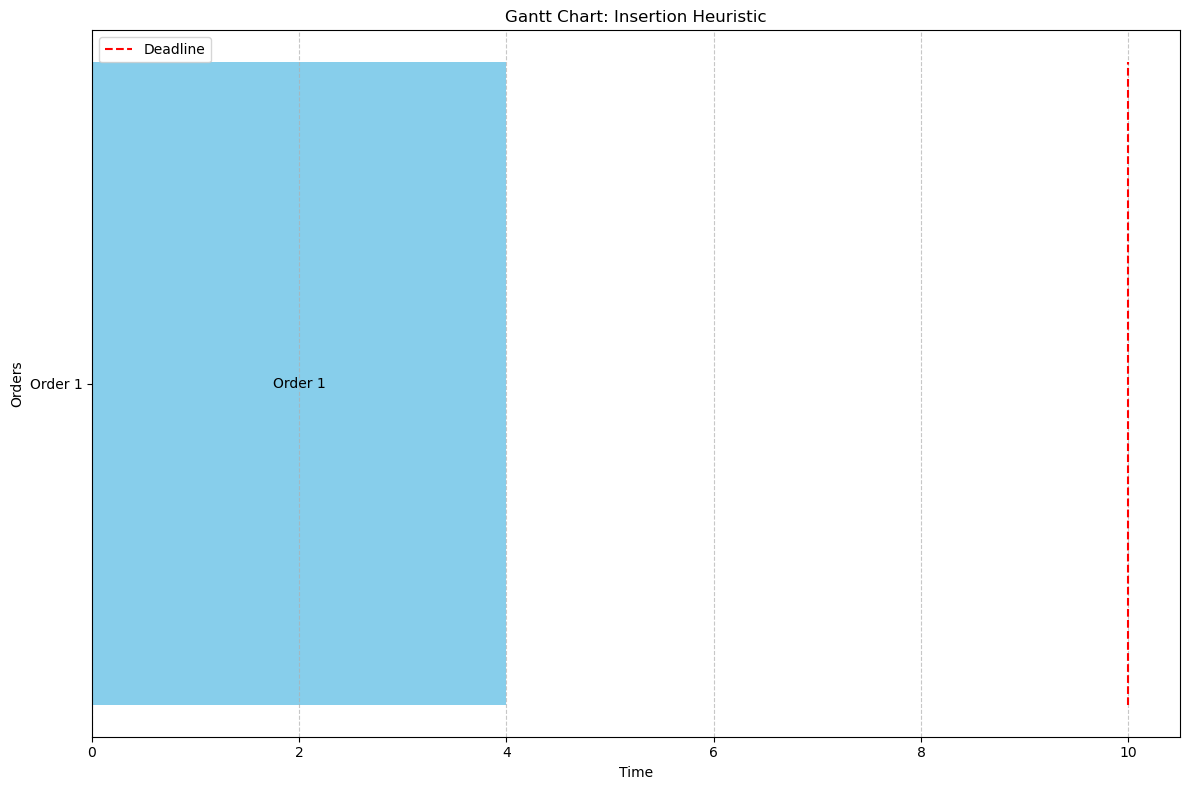

Results for OAS0.txt using Insertion Heuristic:
Scheduled Orders: [1]
Total Profit: 10
Run Time: 0.0020 seconds
--------------------------------------------------


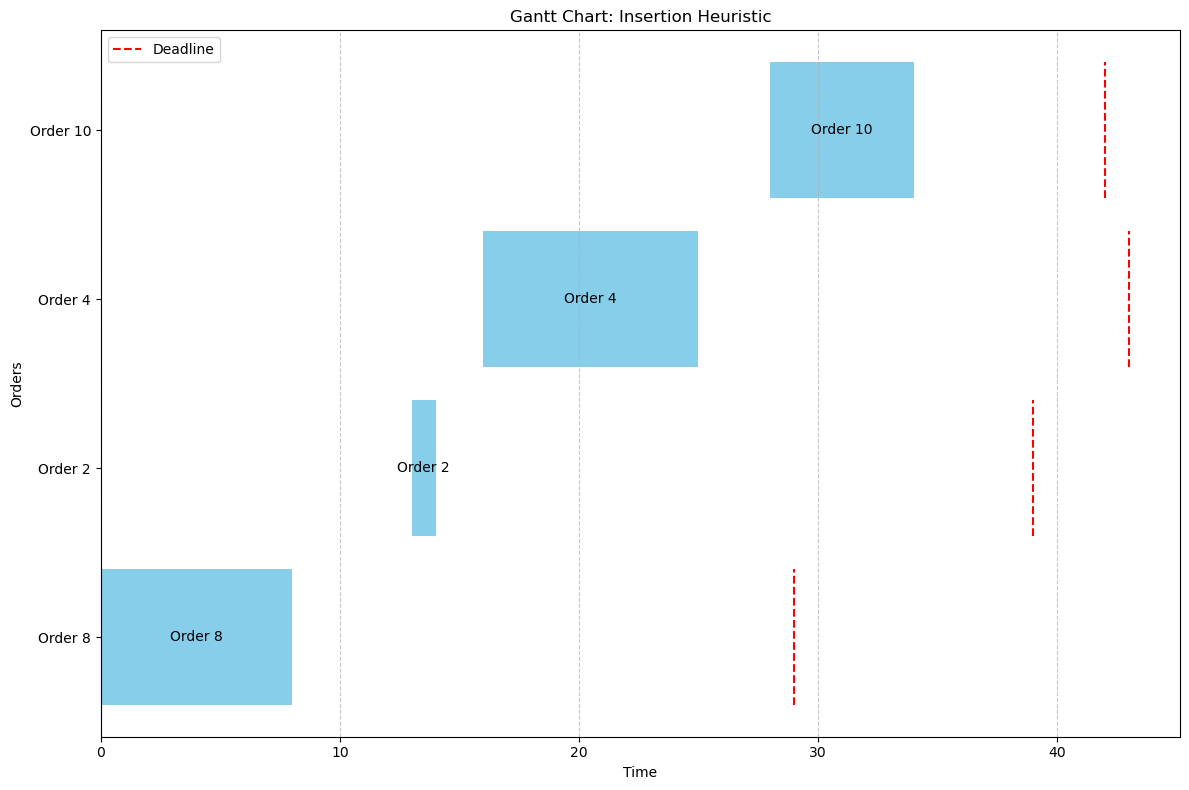

Results for OAS1.txt using Insertion Heuristic:
Scheduled Orders: [8, 2, 4, 10]
Total Profit: 304
Run Time: 0.0030 seconds
--------------------------------------------------


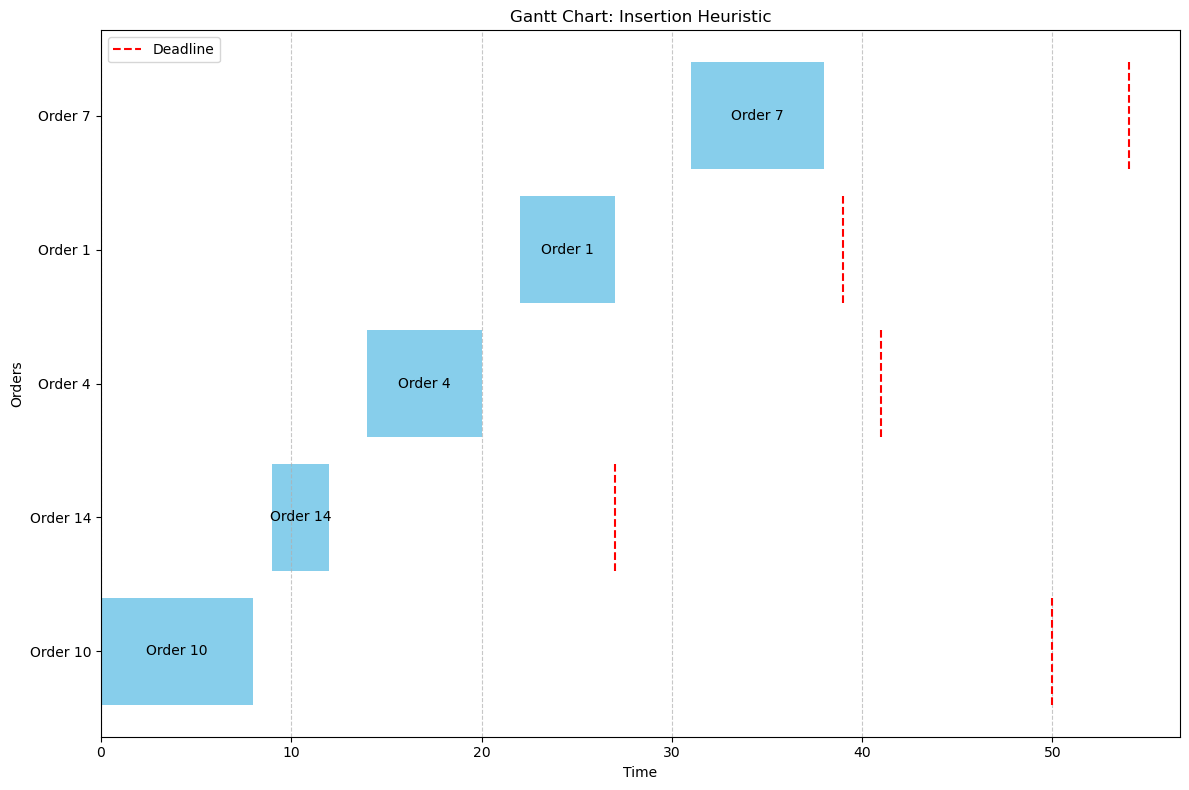

Results for OAS2.txt using Insertion Heuristic:
Scheduled Orders: [10, 14, 4, 1, 7]
Total Profit: 377
Run Time: 0.0212 seconds
--------------------------------------------------


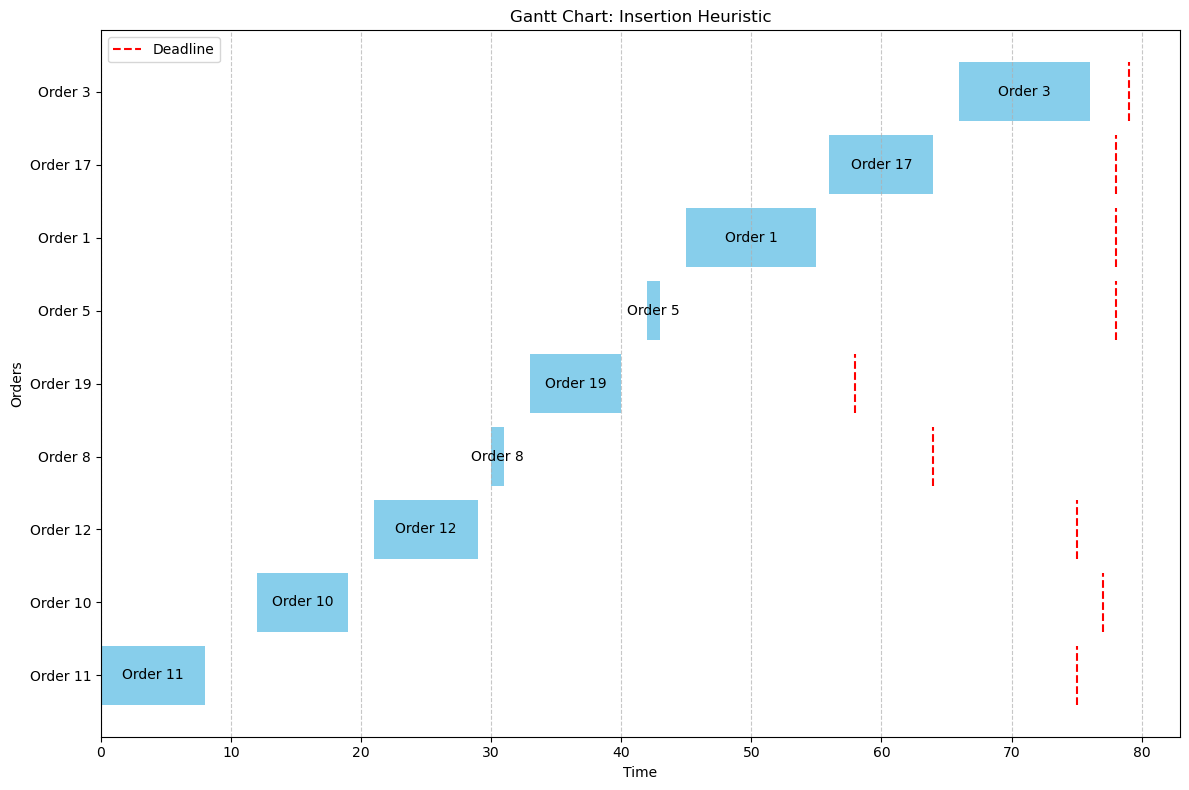

Results for OAS3.txt using Insertion Heuristic:
Scheduled Orders: [11, 10, 12, 8, 19, 5, 1, 17, 3]
Total Profit: 634
Run Time: 0.0271 seconds
--------------------------------------------------


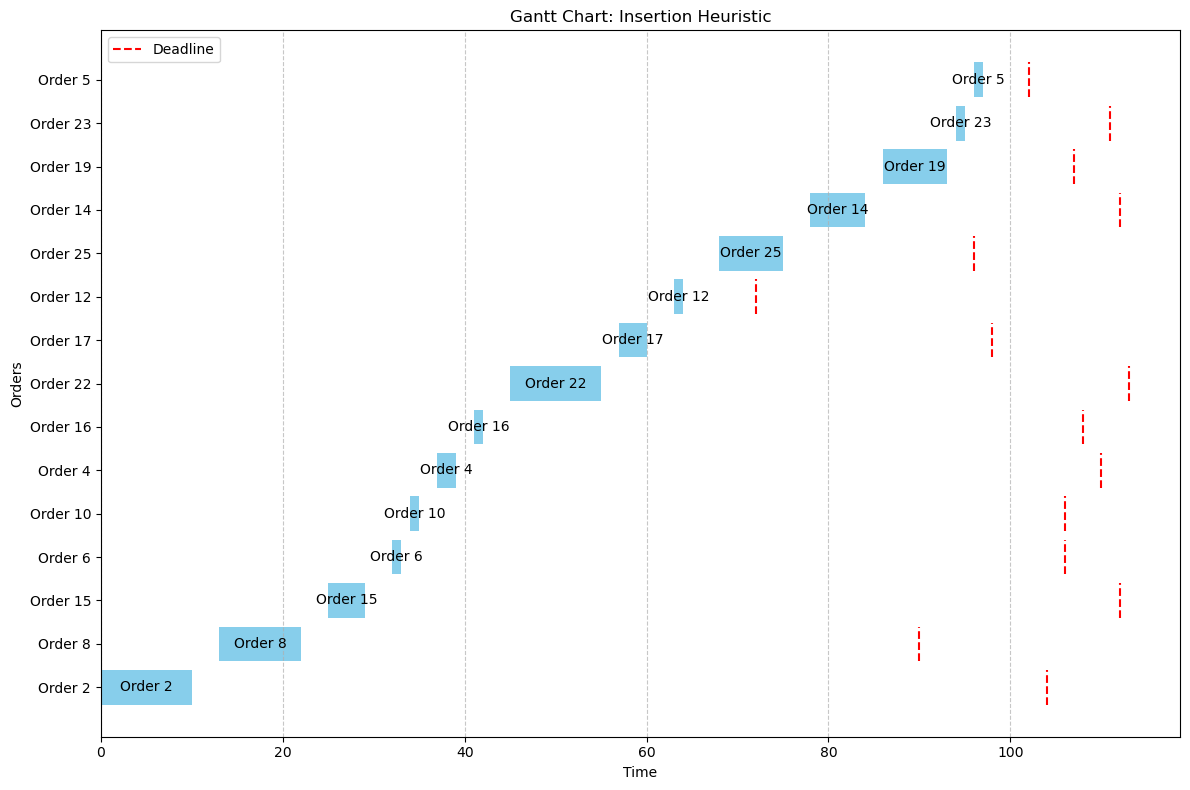

Results for OAS4.txt using Insertion Heuristic:
Scheduled Orders: [2, 8, 15, 6, 10, 4, 16, 22, 17, 12, 25, 14, 19, 23, 5]
Total Profit: 762
Run Time: 0.0441 seconds
--------------------------------------------------


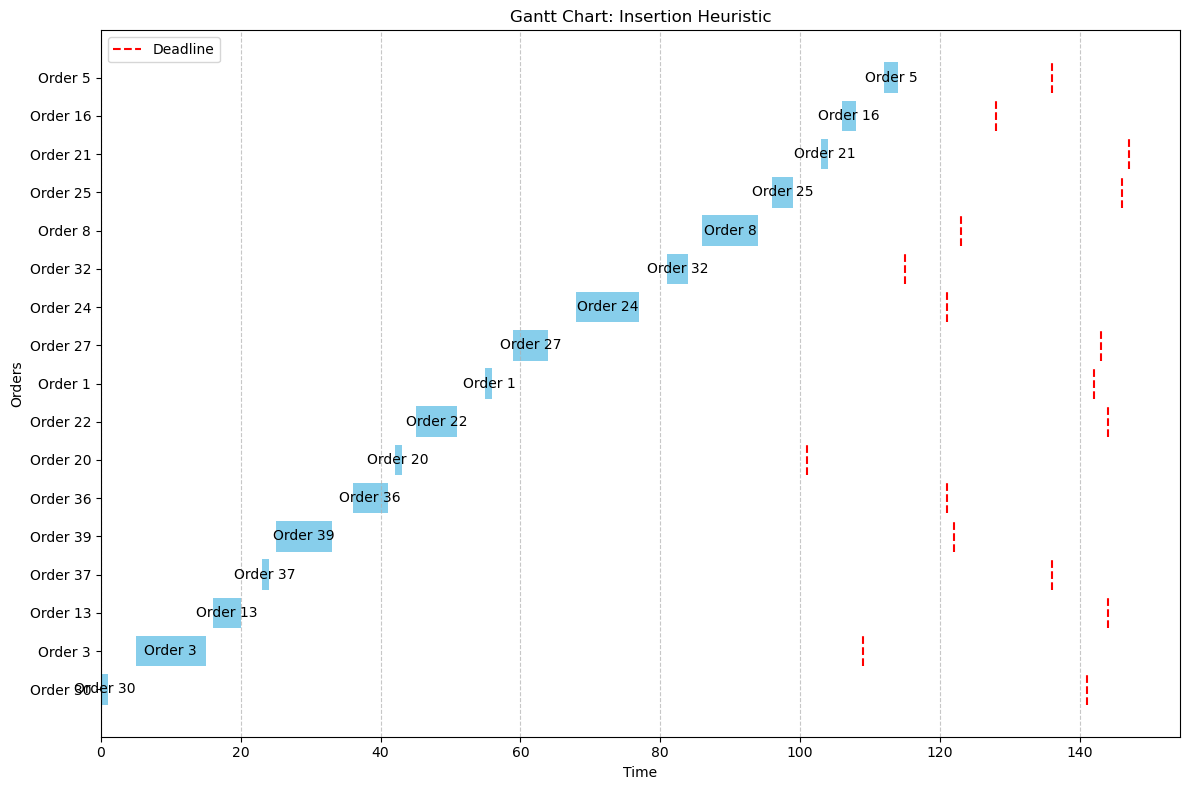

Results for OAS5.txt using Insertion Heuristic:
Scheduled Orders: [30, 3, 13, 37, 39, 36, 20, 22, 1, 27, 24, 32, 8, 25, 21, 16, 5]
Total Profit: 1079
Run Time: 0.0658 seconds
--------------------------------------------------


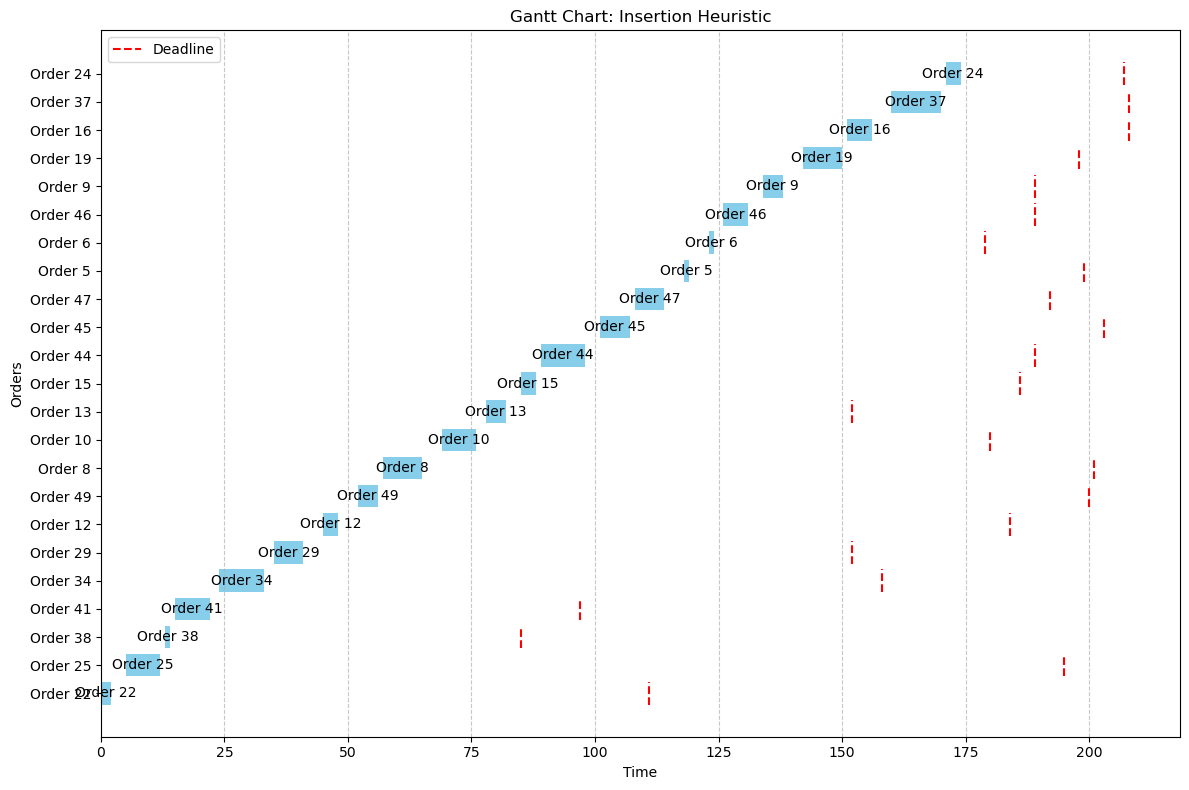

Results for OAS6.txt using Insertion Heuristic:
Scheduled Orders: [22, 25, 38, 41, 34, 29, 12, 49, 8, 10, 13, 15, 44, 45, 47, 5, 6, 46, 9, 19, 16, 37, 24]
Total Profit: 1560
Run Time: 0.1107 seconds
--------------------------------------------------


In [10]:
for file_name in file_names:
    Run_and_visualize(file_name, insertion, "Insertion Heuristic")

#### **4.2 Savings Heuristic**

- ***code :***

In [44]:
import random

def savings(duration, profit, dueDate, deadline, tardCost, numberOrders, setup):
    """
    Savings heuristic: Starts from a solution with all orders (infeasible) and iteratively remove
    the order with the lowest profit until the solution is feasible.
    """
    # Start with all orders in the solution (neglect infeasibility) and shuffle the list
    scheduled_orders = list(range(numberOrders))
    random.shuffle(scheduled_orders)
    
    # Calculate initial start and finish times
    start_times, finish_times = cal(duration, setup, scheduled_orders)
    total_duration = finish_times[-1] if finish_times.size > 0 else 0  # Total duration based on the last finish time
    
    # Check if the initial schedule is feasible
    if savings_feasible(start_times, finish_times, scheduled_orders, deadline, total_duration):
        total_profit = sum(profit[o] for o in scheduled_orders)  # Total profit of all scheduled orders
        return scheduled_orders, total_profit

    while not savings_feasible(start_times, finish_times, scheduled_orders, deadline, total_duration) and scheduled_orders:

        min_profit_order = min(scheduled_orders, key=lambda o: profit[o])
        
        scheduled_orders.remove(min_profit_order)
        
        start_times, finish_times = cal(duration, setup, scheduled_orders)
        total_duration = finish_times[-1] if finish_times.size > 0 else 0

    total_profit = sum(profit[o] for o in scheduled_orders)

    return scheduled_orders, total_profit


def savings_feasible(start_times, finish_times, scheduled_orders, deadline, total_duration):
    """
    Checks if the solution is feasible based on the provided conditions:
    """
    for idx, order in enumerate(scheduled_orders):
        # Overlapping tasks
        if idx > 0 and start_times[idx] < finish_times[idx - 1]:
            return False 
        
        # Deadline exceeded
        if finish_times[idx] > deadline[order]:
            return False  
    return True 

- ***Visualize :***

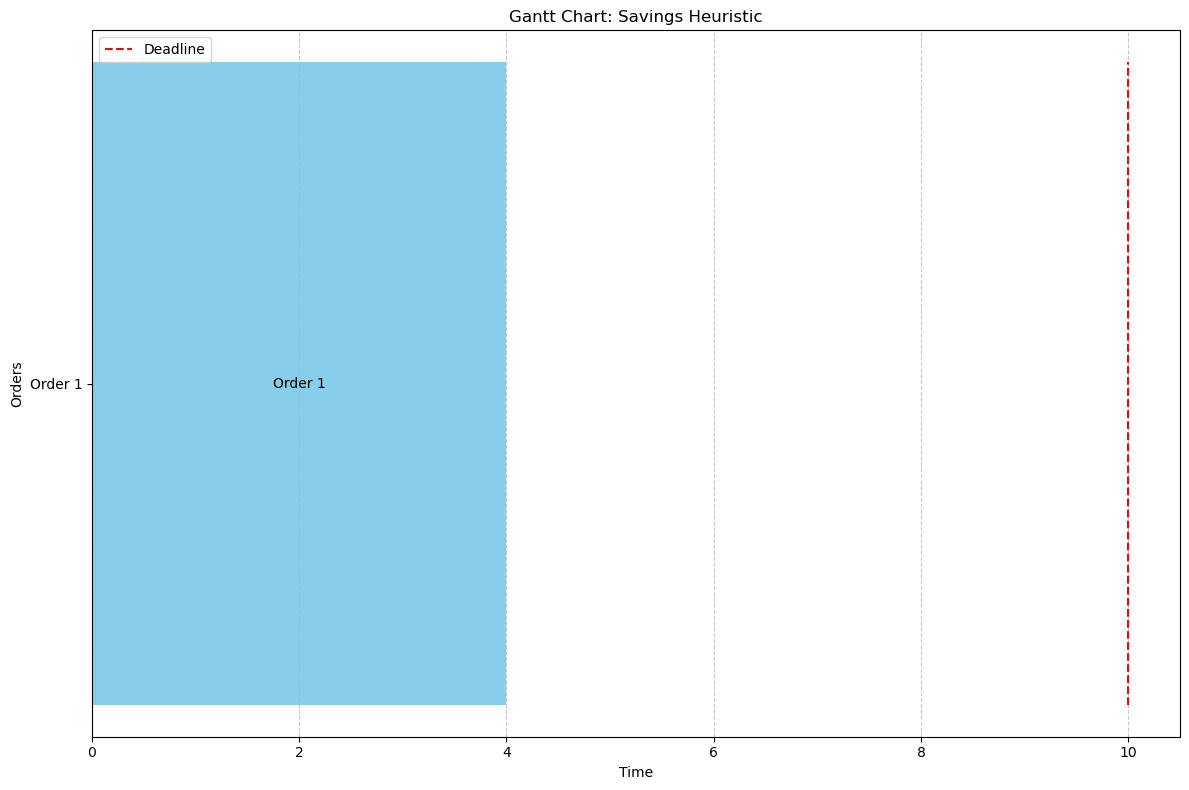

Results for OAS0.txt using Savings Heuristic:
Scheduled Orders: [1]
Total Profit: 10
Run Time: 0.0024 seconds
--------------------------------------------------


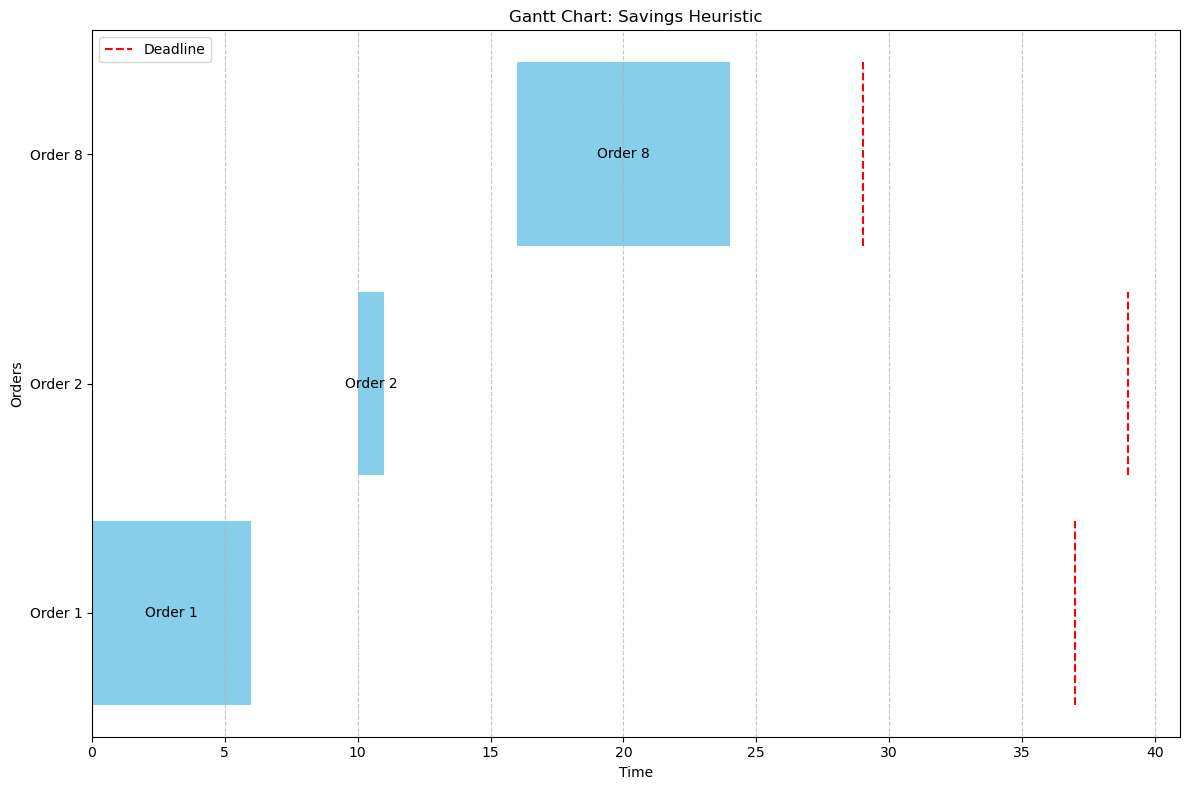

Results for OAS1.txt using Savings Heuristic:
Scheduled Orders: [1, 2, 8]
Total Profit: 246
Run Time: 0.0010 seconds
--------------------------------------------------


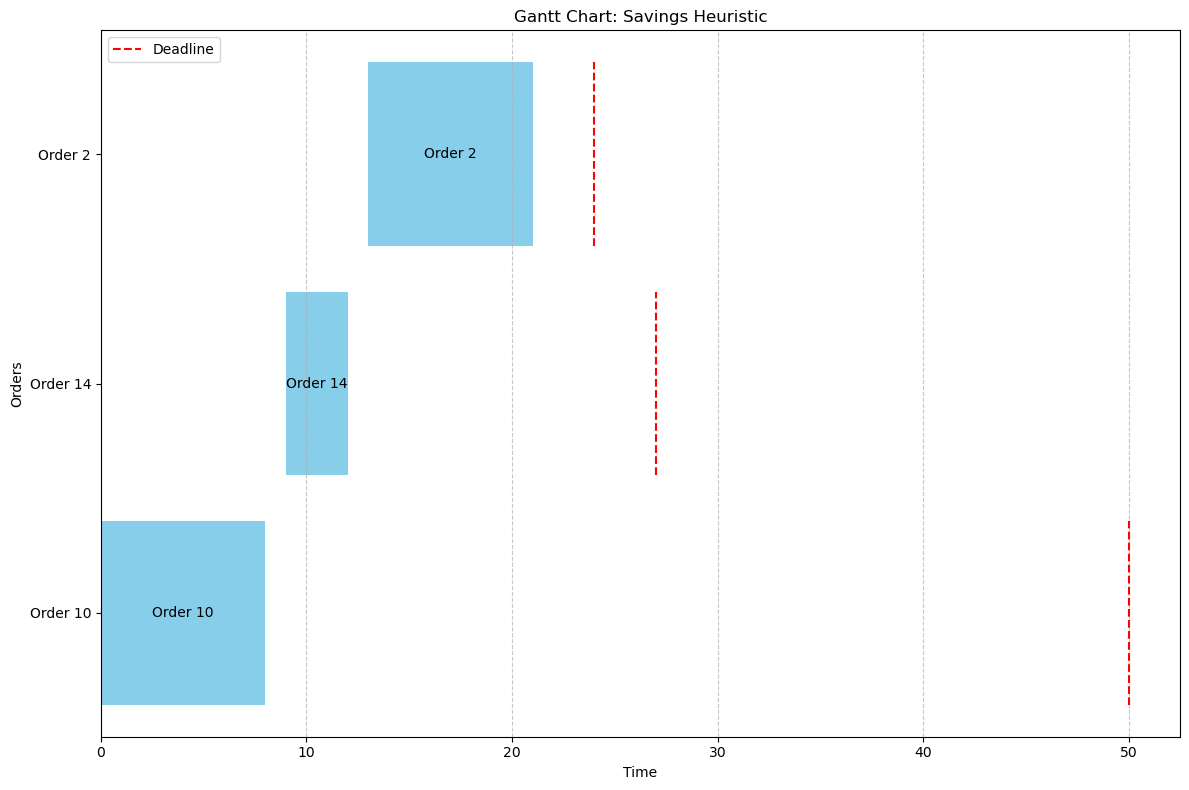

Results for OAS2.txt using Savings Heuristic:
Scheduled Orders: [10, 14, 2]
Total Profit: 264
Run Time: 0.0008 seconds
--------------------------------------------------


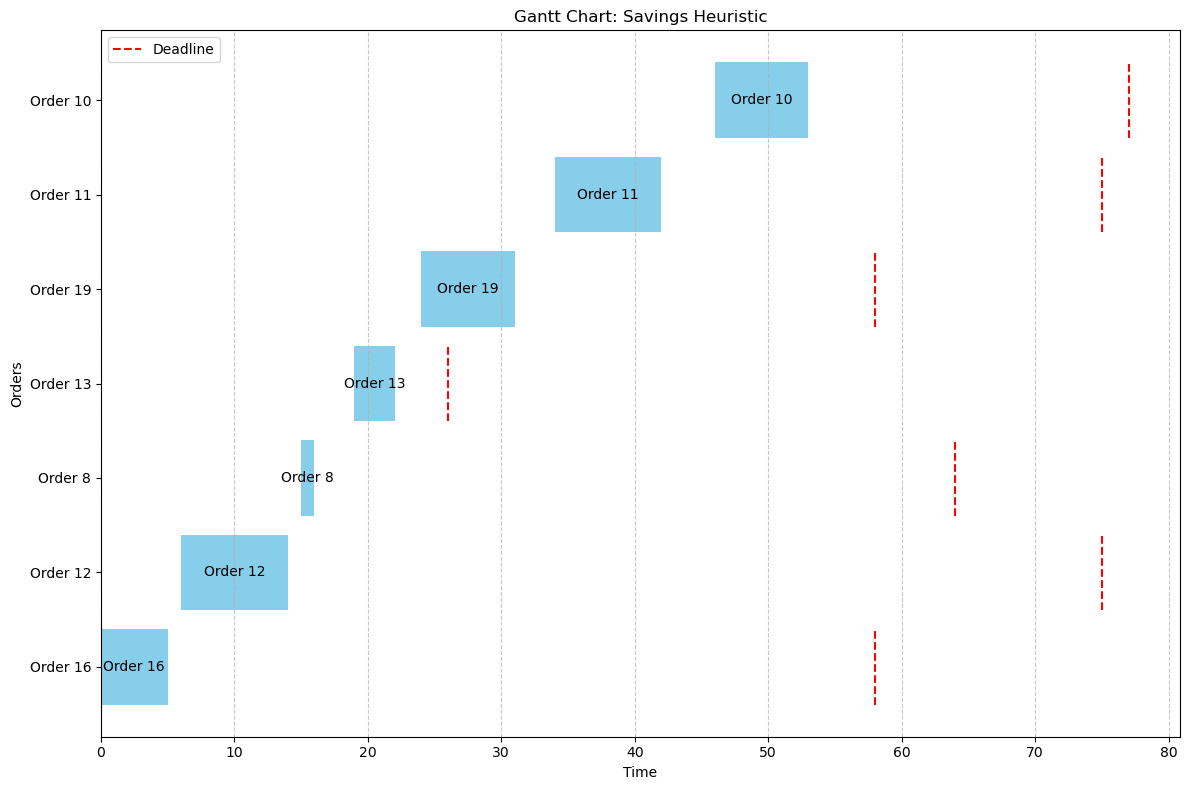

Results for OAS3.txt using Savings Heuristic:
Scheduled Orders: [16, 12, 8, 13, 19, 11, 10]
Total Profit: 606
Run Time: 0.0035 seconds
--------------------------------------------------


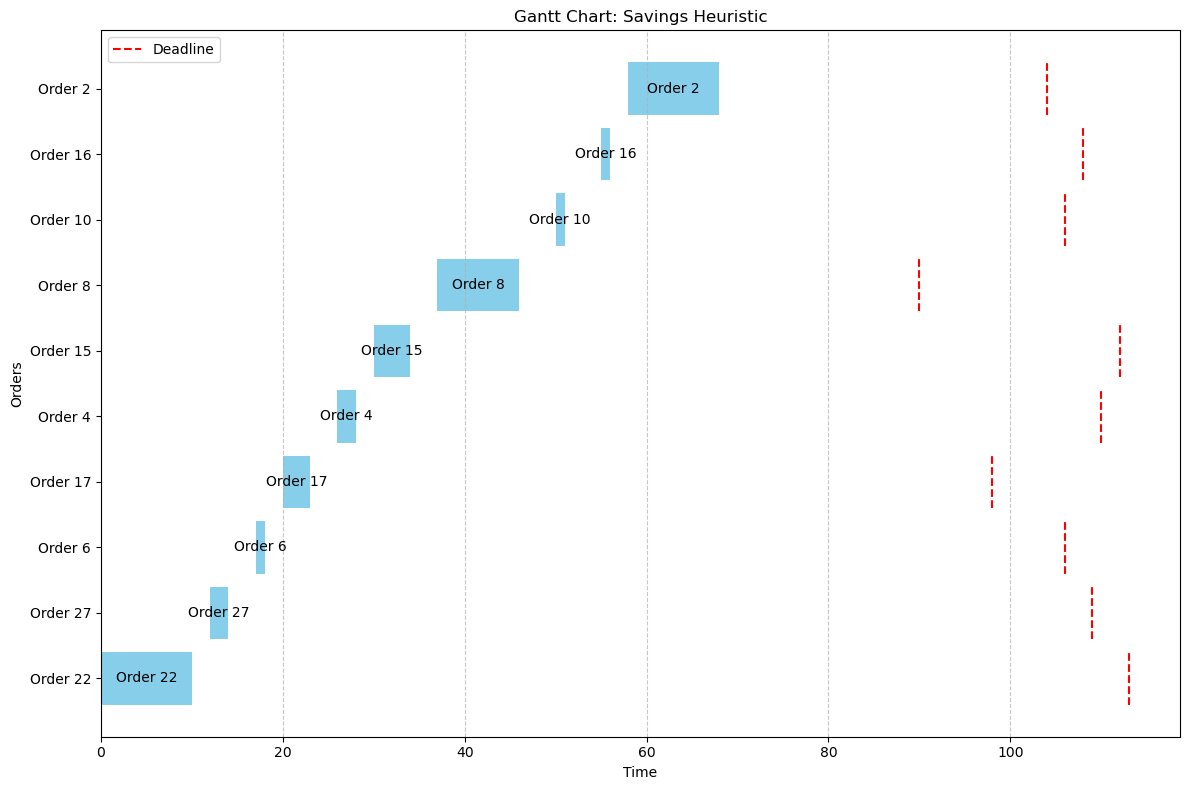

Results for OAS4.txt using Savings Heuristic:
Scheduled Orders: [22, 27, 6, 17, 4, 15, 8, 10, 16, 2]
Total Profit: 700
Run Time: 0.0040 seconds
--------------------------------------------------


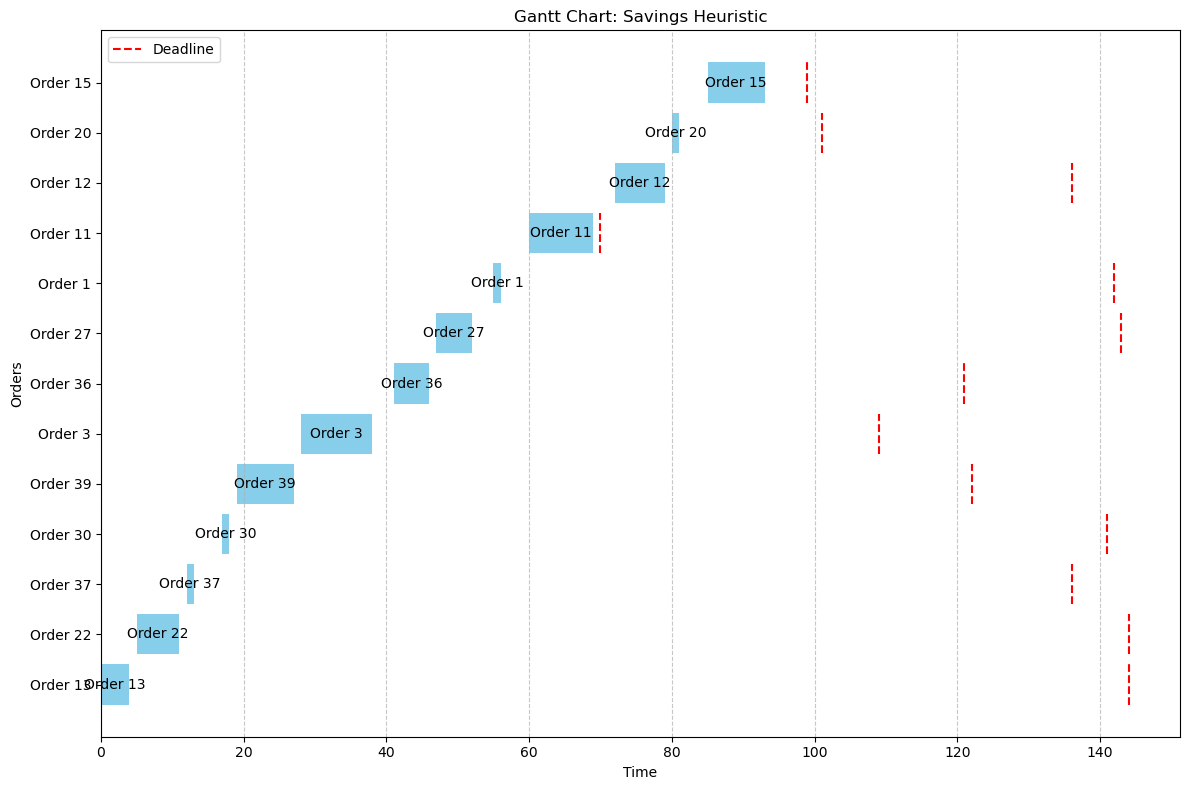

Results for OAS5.txt using Savings Heuristic:
Scheduled Orders: [13, 22, 37, 30, 39, 3, 36, 27, 1, 11, 12, 20, 15]
Total Profit: 1058
Run Time: 0.0025 seconds
--------------------------------------------------


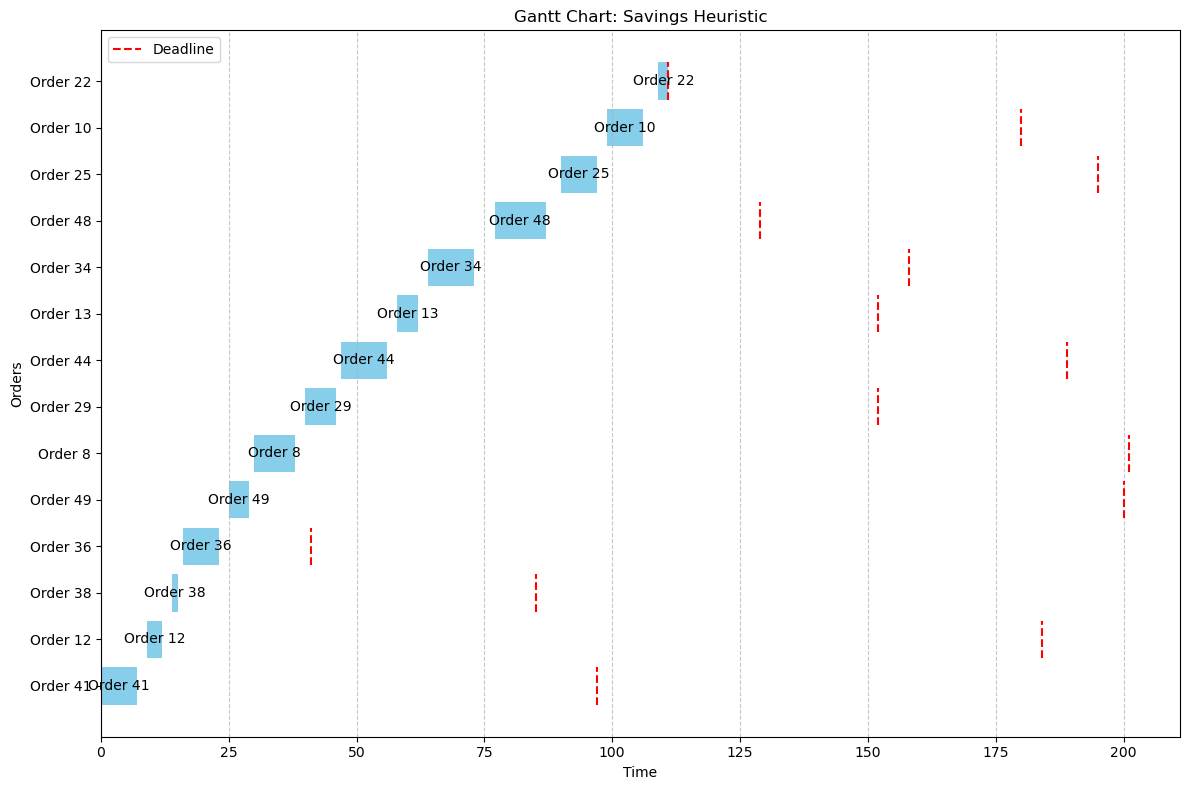

Results for OAS6.txt using Savings Heuristic:
Scheduled Orders: [41, 12, 38, 36, 49, 8, 29, 44, 13, 34, 48, 25, 10, 22]
Total Profit: 1146
Run Time: 0.0084 seconds
--------------------------------------------------


In [45]:
for file_name in file_names:
    Run_and_visualize(file_name, savings, "Savings Heuristic")

#### **4.3 Construction Heuristics:**

In [13]:
import heapq

def construct(duration, profit, dueDate, deadline, tardCost, numberOrders, setup):
    """
    Construct Heuristic for Scheduling with a priority queue.
    Selects orders to maximize profitability while checking feasibility.
    """
    numberOrders = len(duration)
    remaining_orders = list(range(numberOrders))
    schedule = []
    total_duration = 0
    total_profit = 0

    def score(order, prev_order=None):
        """
        Calculate a score for an order based on profitability, setup time, and tardiness penalties.
        """
        if prev_order is None:
            return profit[order] / duration[order]
        else:
            setup_time = setup[prev_order][order]
            tardiness_penalty = (
                tardCost[order] * max(0, total_duration + setup_time + duration[order] - dueDate[order])
            )
            return profit[order] / (duration[order] + setup_time) - tardiness_penalty

    def construct_feasible(sequence):
        """
        Check the feasibility of the current sequence
        """
        start_times, finish_times = cal(duration, setup, sequence)

        for idx, order in enumerate(sequence):
            if idx > 0:
                if start_times[idx] < finish_times[idx - 1]:
                    return False

            if finish_times[idx] > deadline[order]:
                return False

        return True

    # Priority Queue (min-heap) based on negative score to simulate max-heap behavior
    priority_queue = []
    for i in remaining_orders:
        heapq.heappush(priority_queue, (-score(i), i))

    while priority_queue:
        _, best_order = heapq.heappop(priority_queue)

        tentative_schedule = schedule + [best_order]

        if construct_feasible(tentative_schedule):
            schedule.append(best_order)
            remaining_orders.remove(best_order)

            tardiness_penalty = (
                tardCost[best_order] * max(0, total_duration - dueDate[best_order])
            )
            total_profit += profit[best_order] - tardiness_penalty

            setup_time = setup[schedule[-2]][best_order] if len(schedule) > 1 else 0
            total_duration += duration[best_order] + setup_time
        else:
            remaining_orders.remove(best_order)

    return schedule, total_profit

- ***Visualize :***

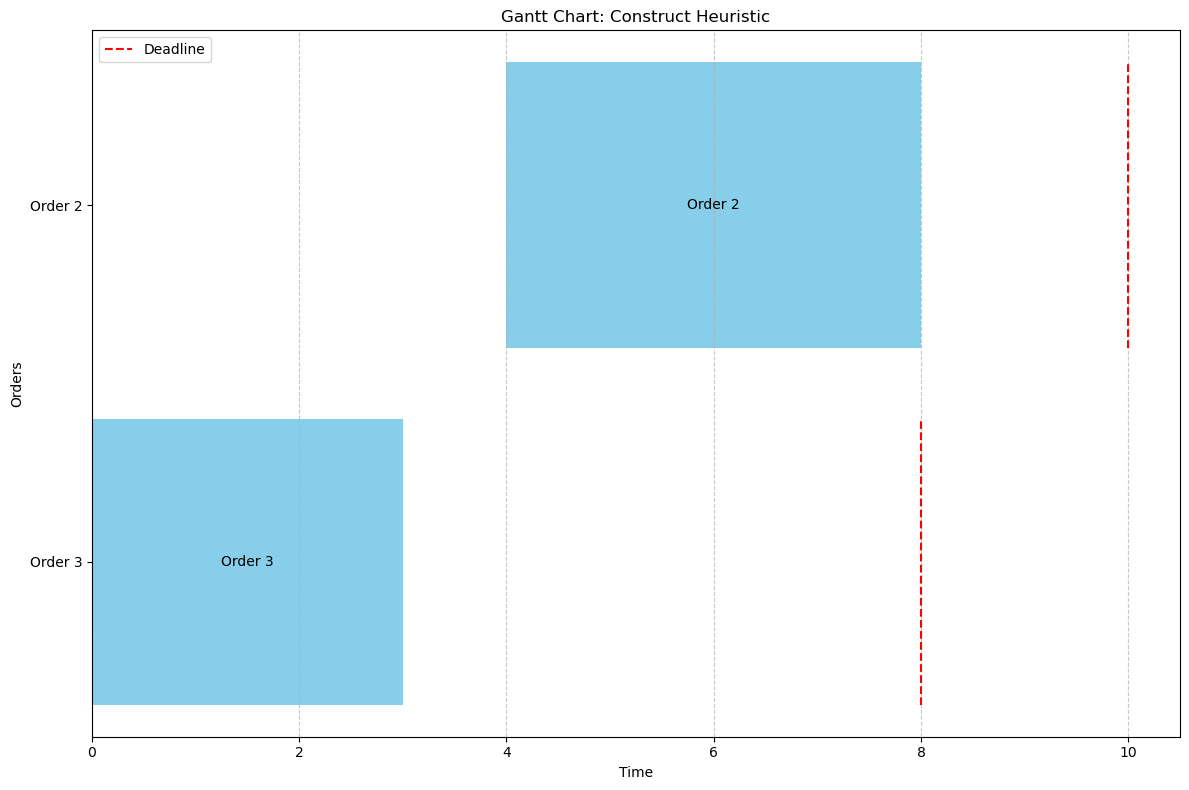

Results for OAS0.txt using Construct Heuristic:
Scheduled Orders: [3, 2]
Total Profit: 13.0
Run Time: 0.0030 seconds
--------------------------------------------------


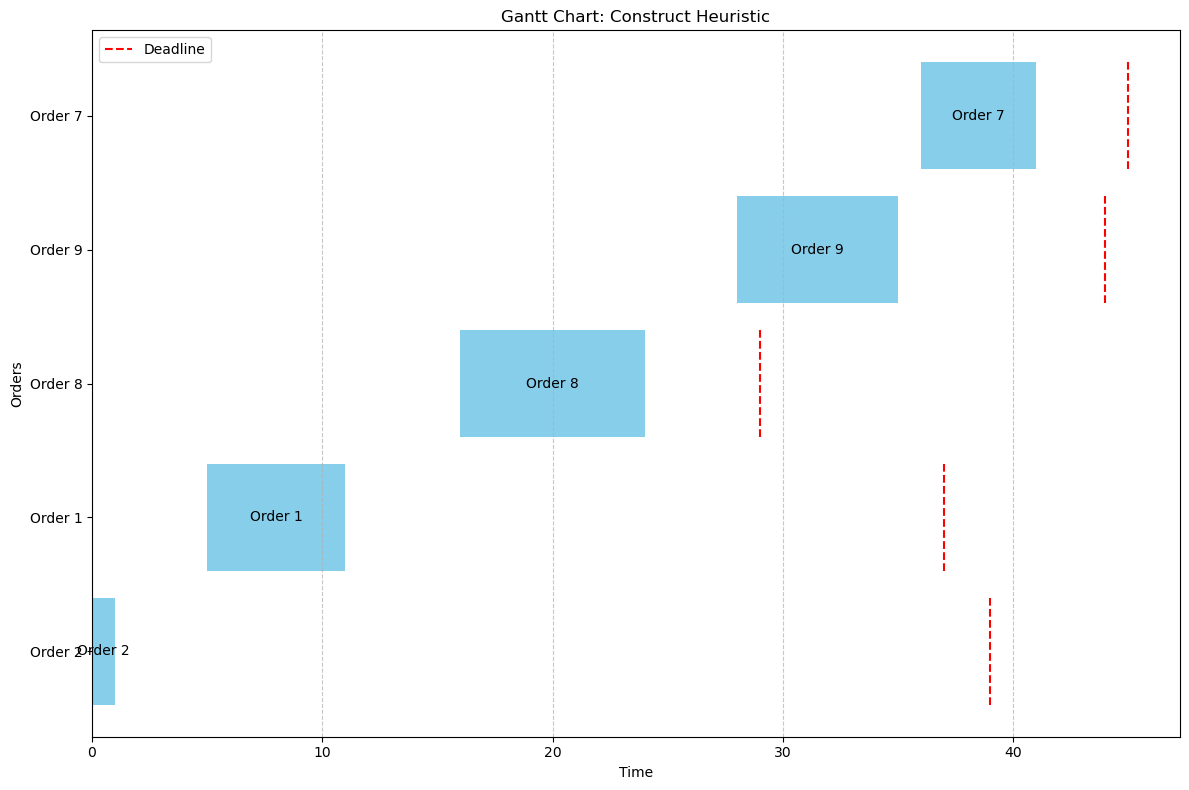

Results for OAS1.txt using Construct Heuristic:
Scheduled Orders: [2, 1, 8, 9, 7]
Total Profit: 354.857144
Run Time: 0.0020 seconds
--------------------------------------------------


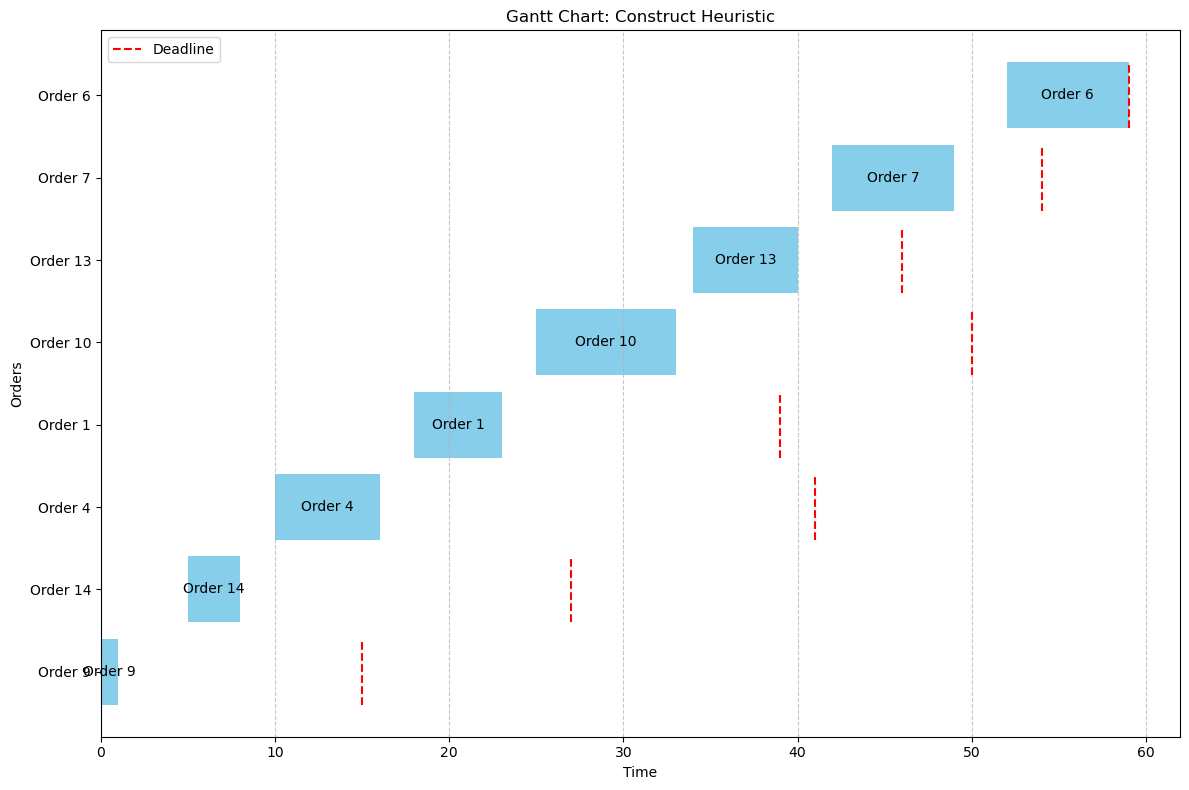

Results for OAS2.txt using Construct Heuristic:
Scheduled Orders: [9, 14, 4, 1, 10, 13, 7, 6]
Total Profit: 477.173359
Run Time: 0.0030 seconds
--------------------------------------------------


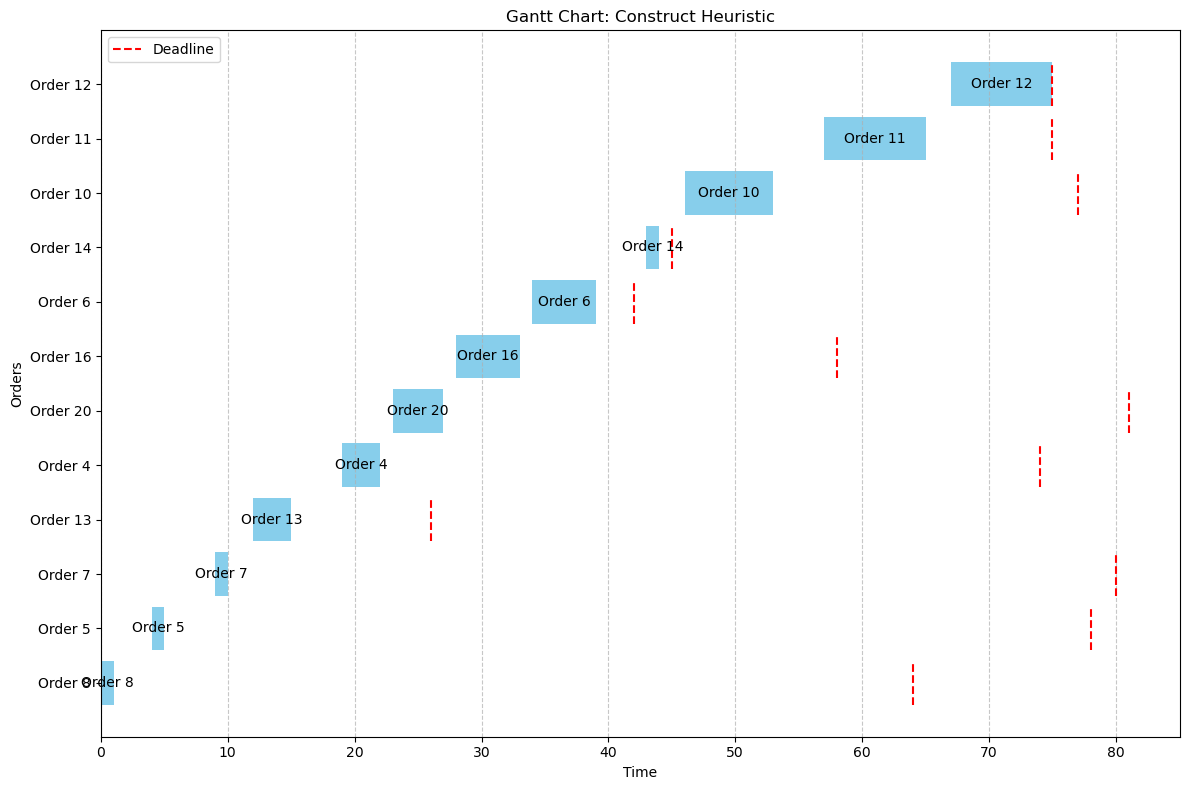

Results for OAS3.txt using Construct Heuristic:
Scheduled Orders: [8, 5, 7, 13, 4, 20, 16, 6, 14, 10, 11, 12]
Total Profit: 677.979476
Run Time: 0.0020 seconds
--------------------------------------------------


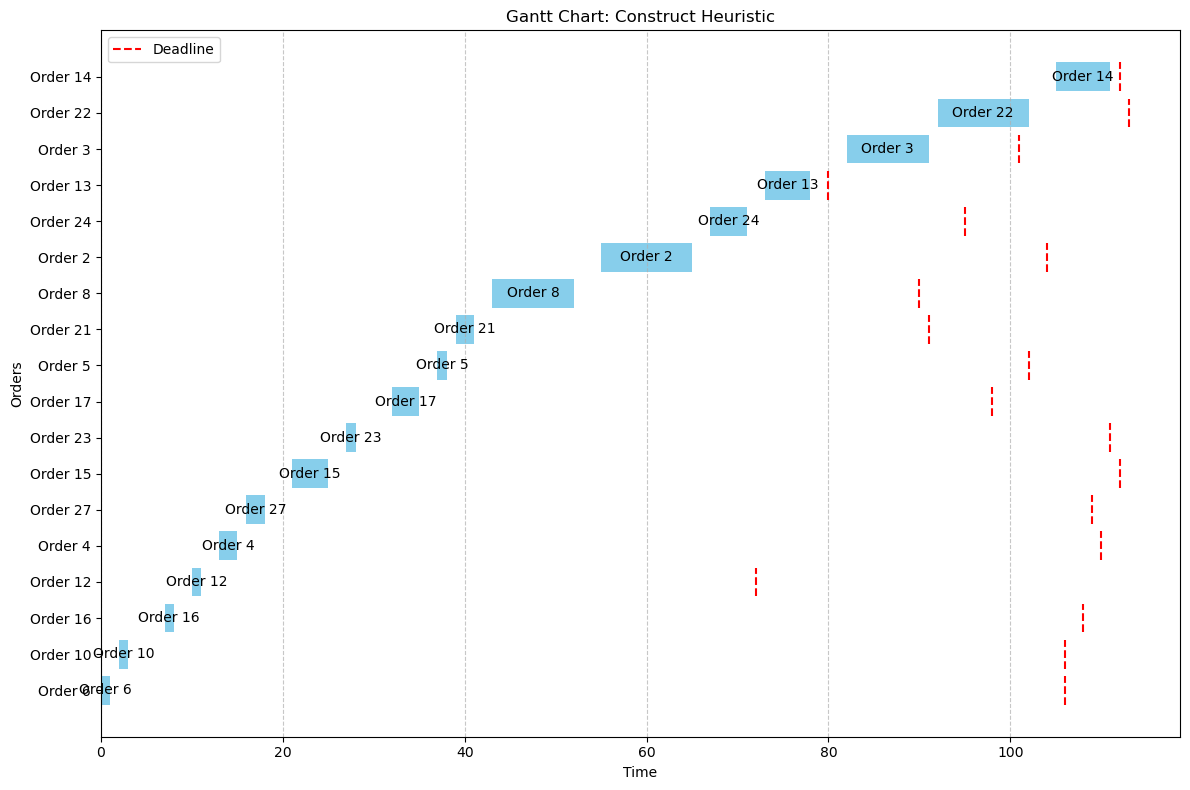

Results for OAS4.txt using Construct Heuristic:
Scheduled Orders: [6, 10, 16, 12, 4, 27, 15, 23, 17, 5, 21, 8, 2, 24, 13, 3, 22, 14]
Total Profit: 862.729634
Run Time: 0.0030 seconds
--------------------------------------------------


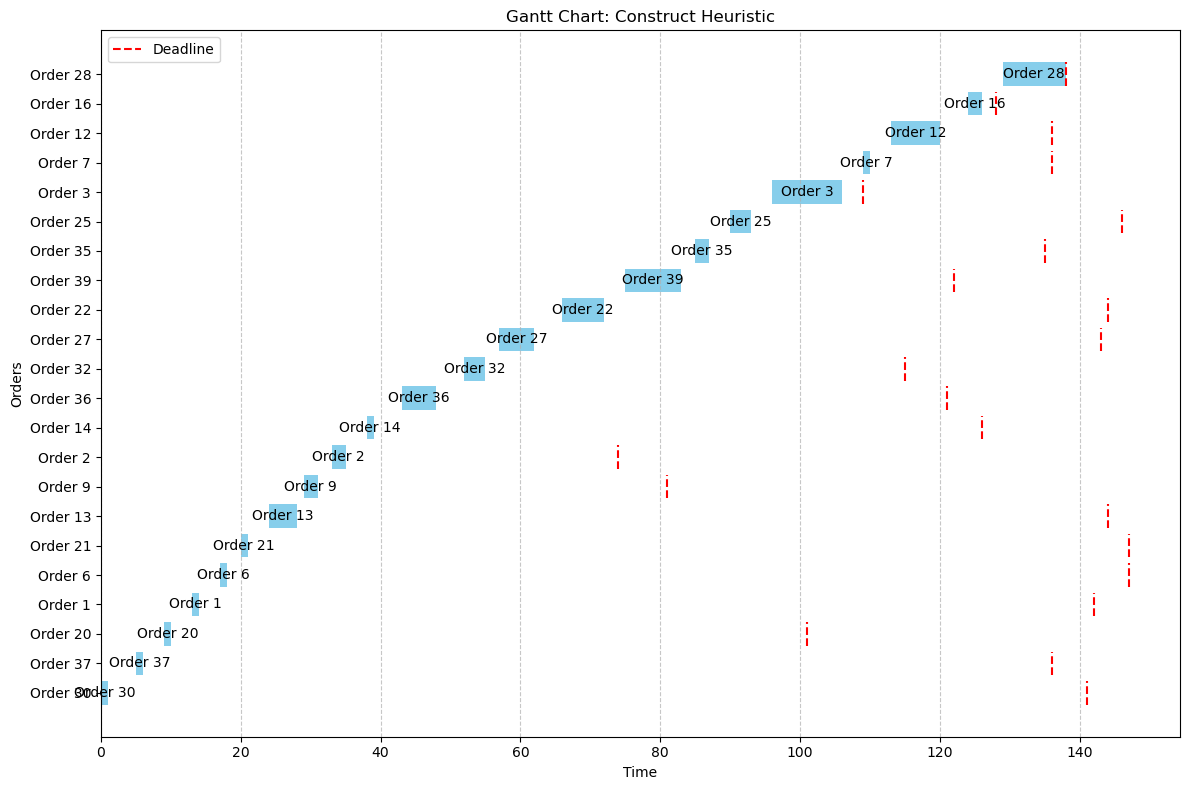

Results for OAS5.txt using Construct Heuristic:
Scheduled Orders: [30, 37, 20, 1, 6, 21, 13, 9, 2, 14, 36, 32, 27, 22, 39, 35, 25, 3, 7, 12, 16, 28]
Total Profit: 1109.7520120000001
Run Time: 0.0100 seconds
--------------------------------------------------


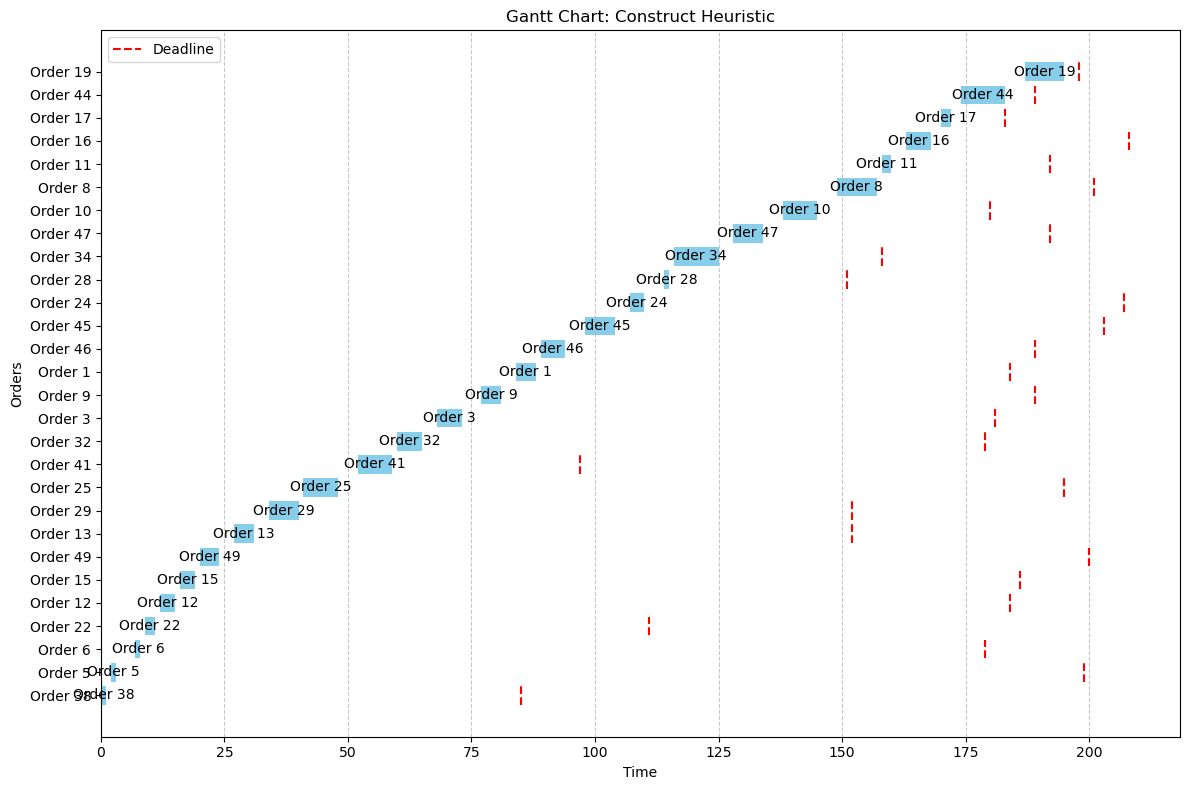

Results for OAS6.txt using Construct Heuristic:
Scheduled Orders: [38, 5, 6, 22, 12, 15, 49, 13, 29, 25, 41, 32, 3, 9, 1, 46, 45, 24, 28, 34, 47, 10, 8, 11, 16, 17, 44, 19]
Total Profit: 1536.0301369999997
Run Time: 0.0060 seconds
--------------------------------------------------


In [14]:
for file_name in file_names:
    Run_and_visualize(file_name, construct, "Construct Heuristic")

### 5. Local Search Improvement Heuristics

#### **Helper Functions**

In [15]:
def Run_and_visualize_improved(file_name, heuristic_function, heuristic_name):
    start_time = time.time()

    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)
    
    initial_solution, _ = construct(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)

    scheduled_orders, total_profit = heuristic_function(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)

    end_time = time.time()

    elapsed_time = end_time - start_time

    visualize(duration, setup, deadline, scheduled_orders, heuristic_name)

    print_results(file_name, scheduled_orders, total_profit, elapsed_time, heuristic_name)


#### **5.1 Move()**

- ***Code : First Accept***

In [16]:
def move(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders):
    """
    Local search using First_Accept.
    Tries to improve the solution by moving an order to a different position or
    adding an order to the schedule.
    """
    def calculate_profit(sequence):
        """
        Evaluates the feasibility and profit of a sequence.
        Returns None if the sequence is infeasible, or the total profit otherwise.
        """
        try:
            start_times, _ = cal(duration, setup, sequence)
            return eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence)
        except Exception:
            return None

    # Track the best solution and its profit
    best_solution = initial_solution.copy()
    best_profit = calculate_profit(best_solution)

    improved = True
    while improved:
        improved = False

        # Try removing each order in the current solution and reinserting it
        for i in range(len(best_solution)):
            # Work on a copy of the current solution
            current_solution = best_solution.copy()
            order_to_move = current_solution.pop(i)  # Remove the order

            for j in range(len(current_solution) + 1):
                tentative_solution = current_solution[:j] + [order_to_move] + current_solution[j:]
                tentative_profit = calculate_profit(tentative_solution)

                if tentative_profit is not None and tentative_profit > best_profit:
                    best_solution = tentative_solution
                    best_profit = tentative_profit
                    improved = True
                    break 

        # Try adding orders not in the current solution
        for order in range(numberOrders):
            if order not in best_solution:
                for j in range(len(best_solution) + 1):
                    tentative_solution = best_solution[:j] + [order] + best_solution[j:]
                    tentative_profit = calculate_profit(tentative_solution)

                    if tentative_profit is not None and tentative_profit > best_profit:
                        best_solution = tentative_solution
                        best_profit = tentative_profit
                        improved = True
                        break 

    return best_solution, best_profit


- ***Visualize :***

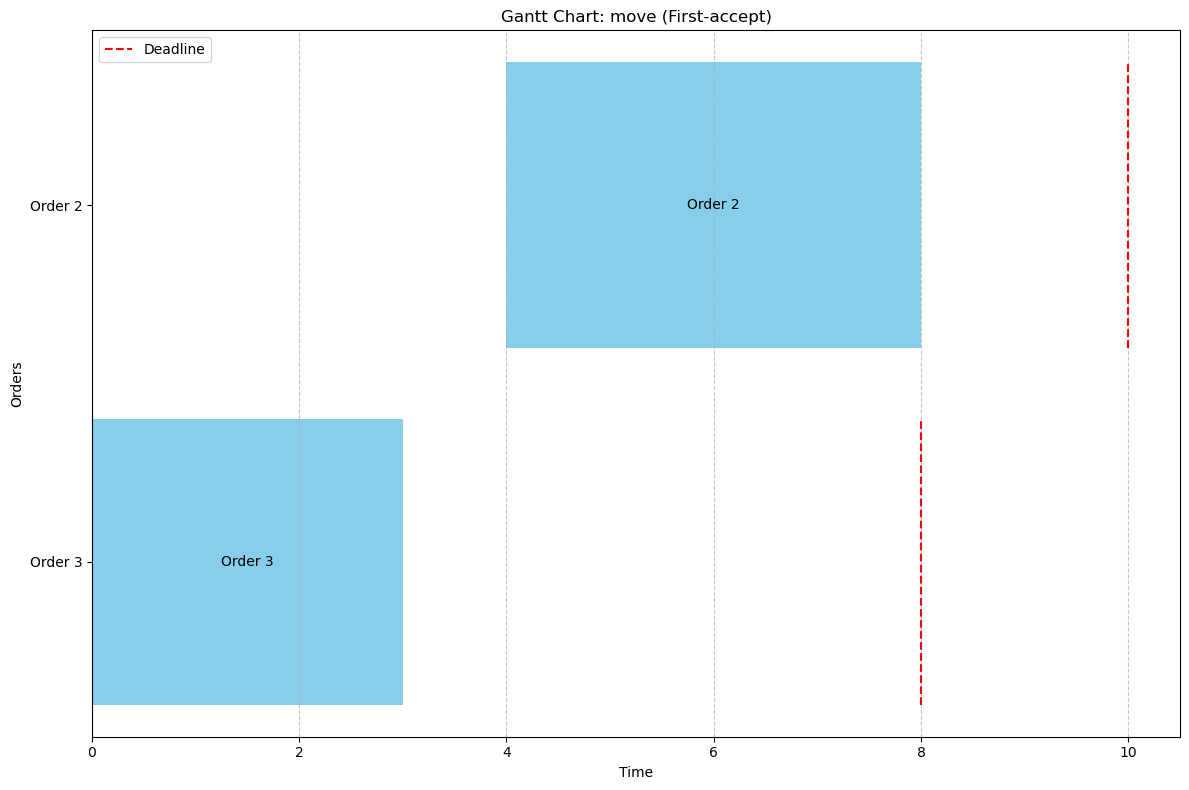

Results for OAS0.txt using move (First-accept):
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0020 seconds
--------------------------------------------------


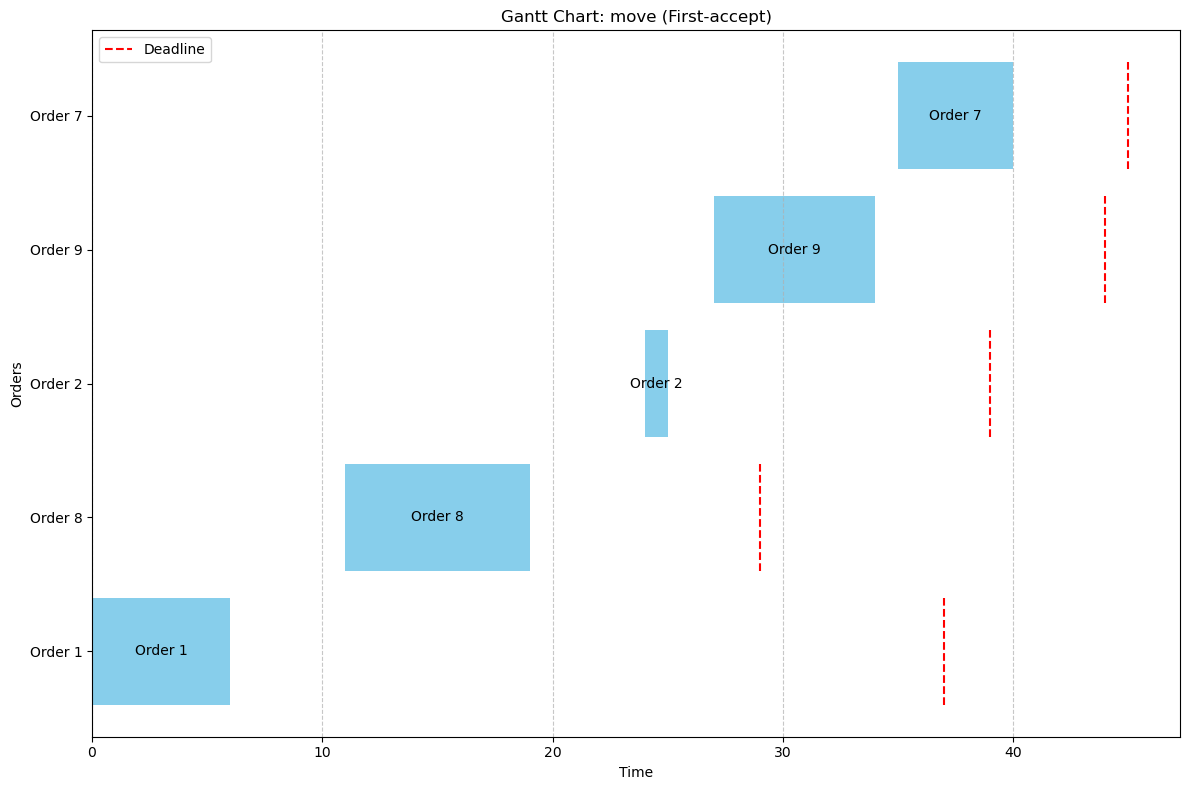

Results for OAS1.txt using move (First-accept):
Scheduled Orders: [1, 8, 2, 9, 7]
Total Profit: 292.428574
Run Time: 0.0070 seconds
--------------------------------------------------


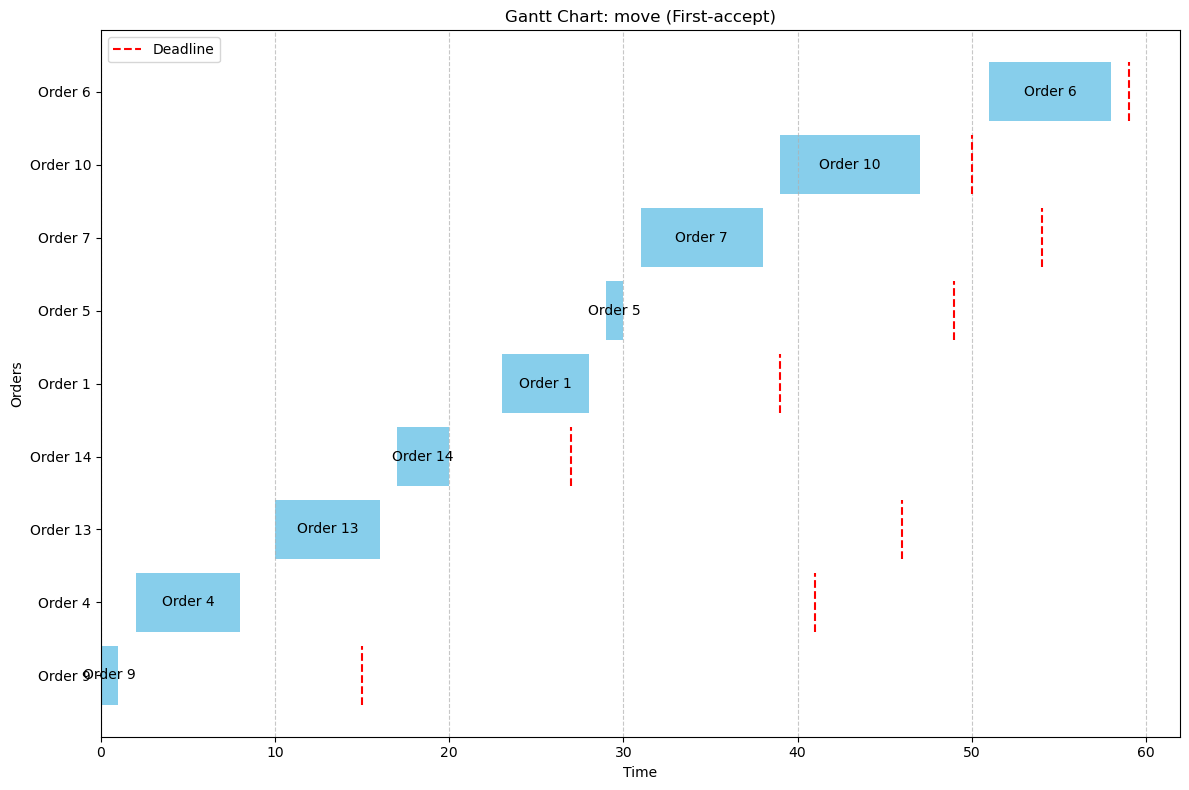

Results for OAS2.txt using move (First-accept):
Scheduled Orders: [9, 4, 13, 14, 1, 5, 7, 10, 6]
Total Profit: 297.748551
Run Time: 0.0228 seconds
--------------------------------------------------


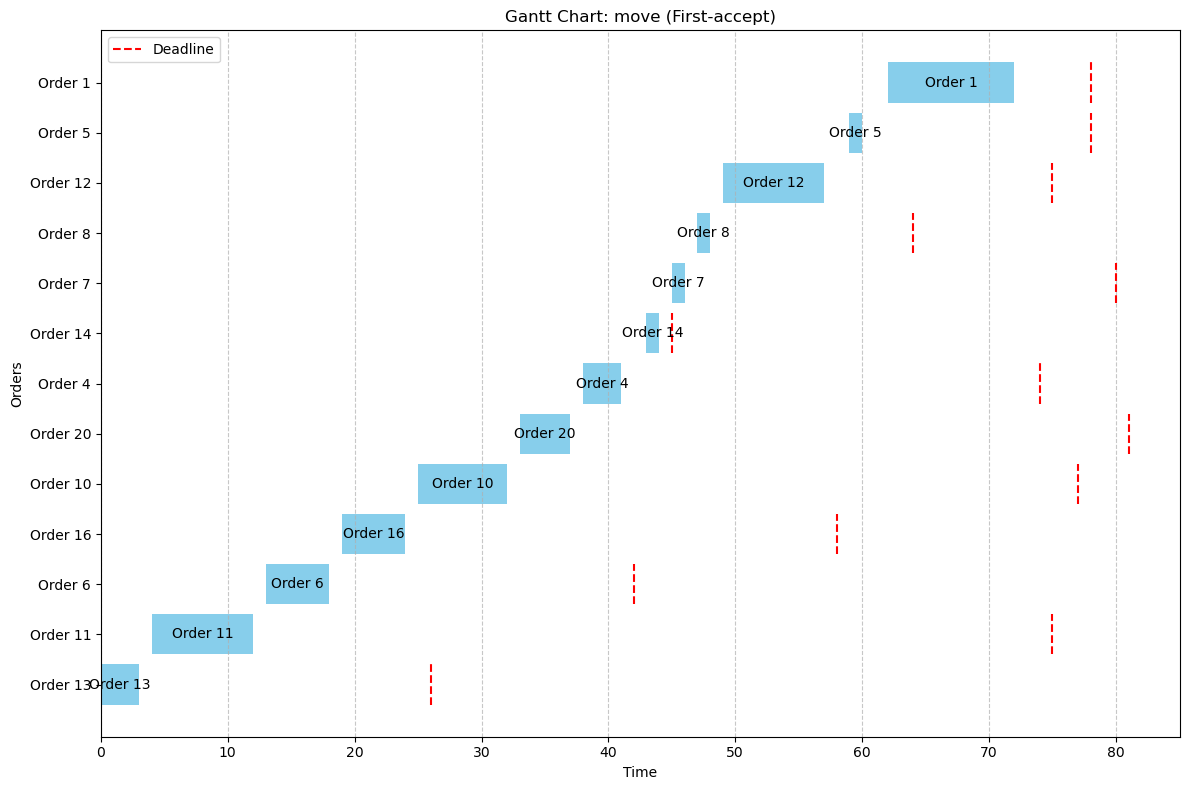

Results for OAS3.txt using move (First-accept):
Scheduled Orders: [13, 11, 6, 16, 10, 20, 4, 14, 7, 8, 12, 5, 1]
Total Profit: 760.872484
Run Time: 0.1615 seconds
--------------------------------------------------


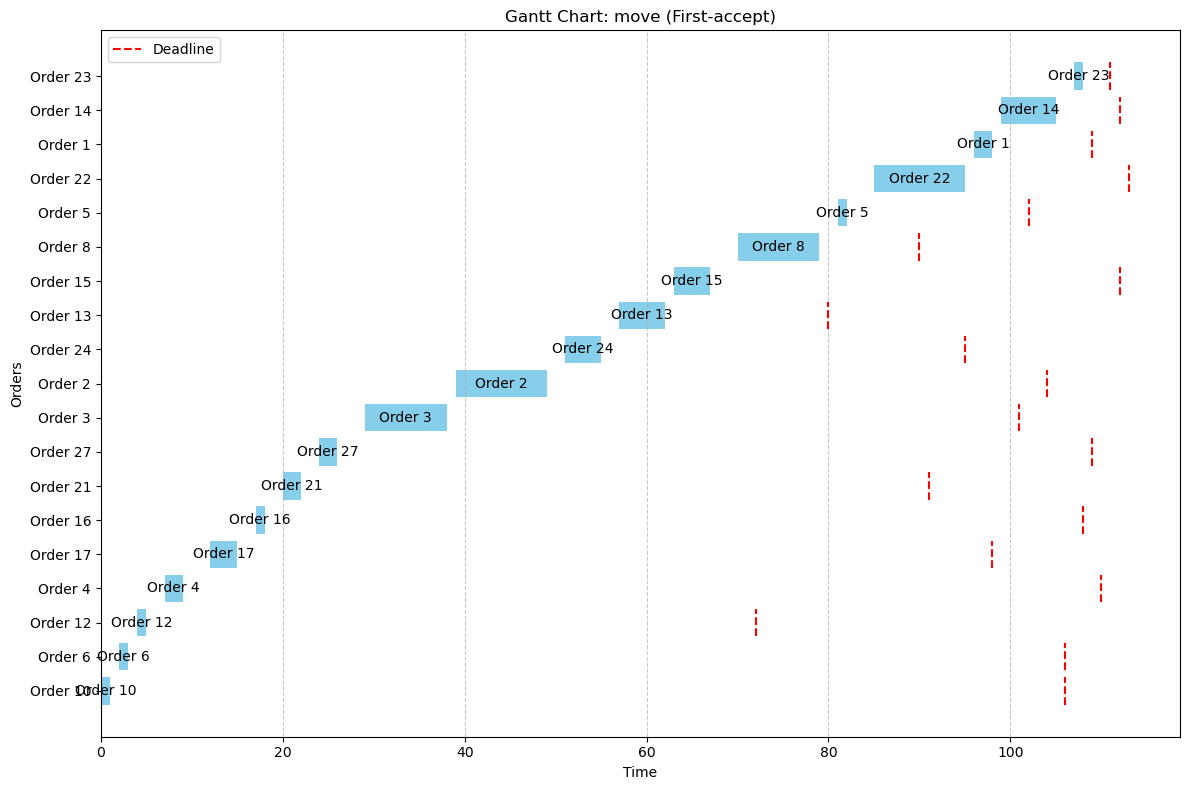

Results for OAS4.txt using move (First-accept):
Scheduled Orders: [10, 6, 12, 4, 17, 16, 21, 27, 3, 2, 24, 13, 15, 8, 5, 22, 1, 14, 23]
Total Profit: 910
Run Time: 0.2513 seconds
--------------------------------------------------


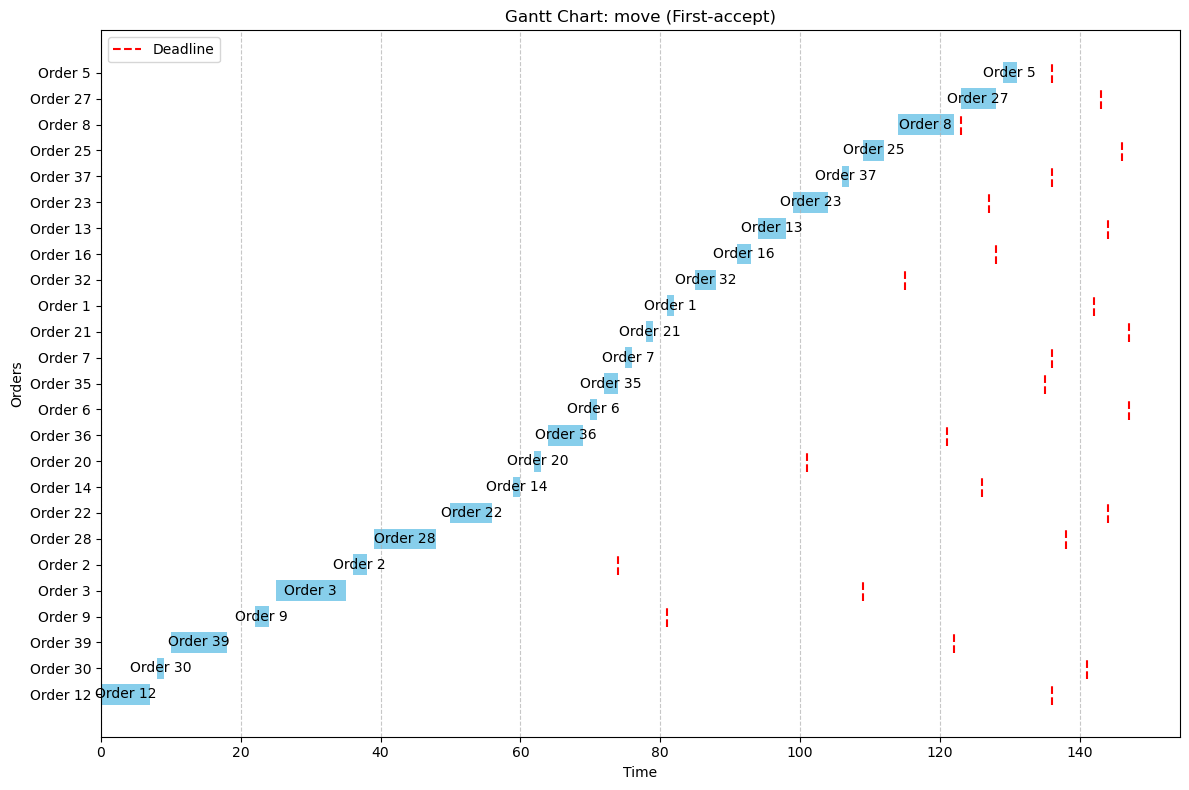

Results for OAS5.txt using move (First-accept):
Scheduled Orders: [12, 30, 39, 9, 3, 2, 28, 22, 14, 20, 36, 6, 35, 7, 21, 1, 32, 16, 13, 23, 37, 25, 8, 27, 5]
Total Profit: 1284
Run Time: 1.9488 seconds
--------------------------------------------------


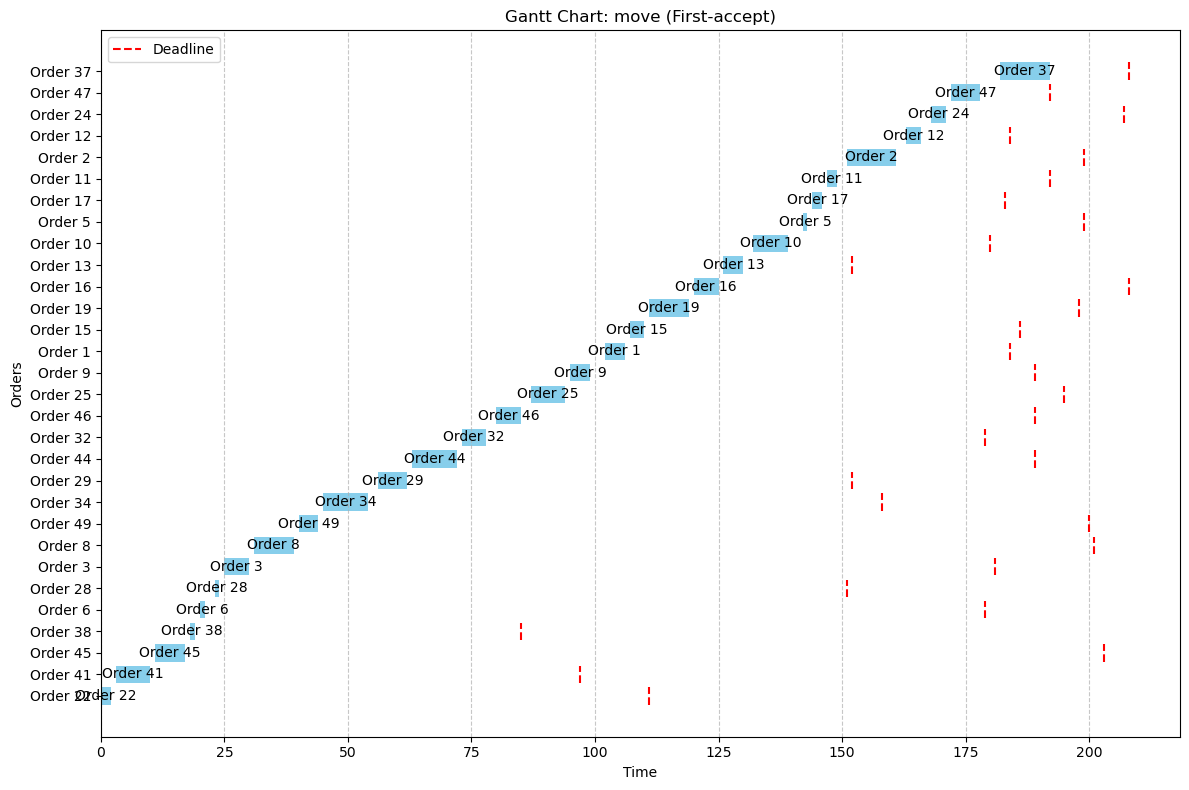

Results for OAS6.txt using move (First-accept):
Scheduled Orders: [22, 41, 45, 38, 6, 28, 3, 8, 49, 34, 29, 44, 32, 46, 25, 9, 1, 15, 19, 16, 13, 10, 5, 17, 11, 2, 12, 24, 47, 37]
Total Profit: 1798
Run Time: 1.3733 seconds
--------------------------------------------------


In [17]:
for file_name in file_names:
    Run_and_visualize_improved(file_name, move, "move (First-accept)")

- ***Code : Best-accept***

In [18]:
def move_best_accept(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders):
    """
    Local search using Best-accept.
    Tries to improve the solution by evaluating all neighbors and selecting the best one.
    """
    def calculate_profit(sequence):
        """
        Evaluates the feasibility and profit of a sequence.
        Returns None if the sequence is infeasible, or the total profit otherwise.
        """
        try:
            start_times, _ = cal(duration, setup, sequence)
            return eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence)
        except Exception:
            return None

    # Track the best solution and its profit
    best_solution = initial_solution.copy()
    best_profit = calculate_profit(best_solution)

    improved = True
    while improved:
        improved = False

        # Try removing each order in the current solution and reinserting it
        for i in range(len(best_solution)):
            current_solution = best_solution.copy()
            order_to_move = current_solution.pop(i) 

            for j in range(len(current_solution) + 1):
                tentative_solution = current_solution[:j] + [order_to_move] + current_solution[j:]
                tentative_profit = calculate_profit(tentative_solution)

                if tentative_profit is not None and tentative_profit > best_profit:
                    best_solution = tentative_solution
                    best_profit = tentative_profit
                    improved = True

        # Try adding orders not in the current solution
        for order in range(numberOrders):
            if order not in best_solution:
                for j in range(len(best_solution) + 1):
                    tentative_solution = best_solution[:j] + [order] + best_solution[j:]
                    tentative_profit = calculate_profit(tentative_solution)

                    if tentative_profit is not None and tentative_profit > best_profit:
                        best_solution = tentative_solution
                        best_profit = tentative_profit
                        improved = True

    return best_solution, best_profit


- ***Run best_accept Move :***

In [19]:
for file_name in file_names:
    def Run_and_visualize_best_accept(file_name, heuristic_function, heuristic_name):
        start_time = time.time()

        duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)
    
        initial_solution, _ = construct(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)

        scheduled_orders, total_profit = heuristic_function(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)

        end_time = time.time()

        elapsed_time = end_time - start_time

        print_results(file_name, scheduled_orders, total_profit, elapsed_time, heuristic_name)

    Run_and_visualize_best_accept(file_name, move_best_accept, "move (Best accept)")

Results for OAS0.txt using move (Best accept):
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0018 seconds
--------------------------------------------------
Results for OAS1.txt using move (Best accept):
Scheduled Orders: [1, 8, 2, 9, 7]
Total Profit: 292.428574
Run Time: 0.0080 seconds
--------------------------------------------------
Results for OAS2.txt using move (Best accept):
Scheduled Orders: [9, 4, 13, 14, 1, 5, 7, 10, 6]
Total Profit: 297.748551
Run Time: 0.0188 seconds
--------------------------------------------------
Results for OAS3.txt using move (Best accept):
Scheduled Orders: [13, 14, 4, 16, 6, 11, 7, 20, 8, 12, 5, 1, 10]
Total Profit: 612.866685
Run Time: 0.1386 seconds
--------------------------------------------------
Results for OAS4.txt using move (Best accept):
Scheduled Orders: [10, 6, 21, 13, 23, 5, 27, 24, 4, 3, 16, 12, 2, 17, 15, 8, 22, 1, 14]
Total Profit: 910
Run Time: 0.4515 seconds
--------------------------------------------------
Results for OA

#### **5.2 Swap()**

- ***Code :***

In [20]:
def swap(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders):
    """
    Local search using Swap.
    Tries to improve the solution by swapping the positions of two orders in the schedule.
    """
    def calculate_profit(sequence):
        """
        Evaluates the feasibility and profit of a sequence.
        Returns None if the sequence is infeasible, or the total profit otherwise.
        """
        try:
            start_times, _ = cal(duration, setup, sequence)
            return eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence)
        except Exception:
            return None

    # Track the best solution and its profit
    best_solution = initial_solution.copy()
    best_profit = calculate_profit(best_solution)

    improved = True
    while improved:
        improved = False

        # Try swapping each pair of orders
        for i in range(len(best_solution)):
            for j in range(i + 1, len(best_solution)):
                # Swap orders i and j
                current_solution = best_solution.copy()
                current_solution[i], current_solution[j] = current_solution[j], current_solution[i]

                tentative_profit = calculate_profit(current_solution)

                # Update the best solution if the swap improves profit
                if tentative_profit is not None and tentative_profit > best_profit:
                    best_solution = current_solution
                    best_profit = tentative_profit
                    improved = True
                    break
            if improved:  # If improvement was found, restart the search
                break

    return best_solution, best_profit

- ***Visualize :***

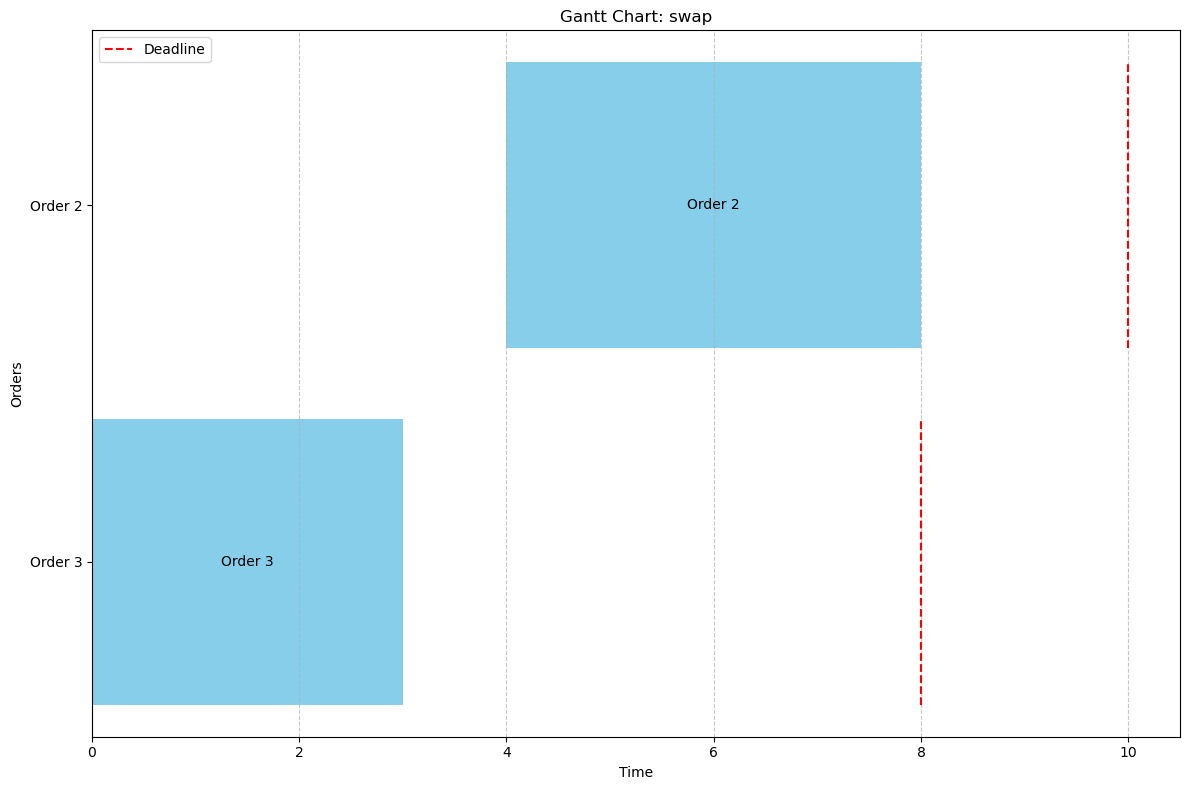

Results for OAS0.txt using swap:
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0030 seconds
--------------------------------------------------


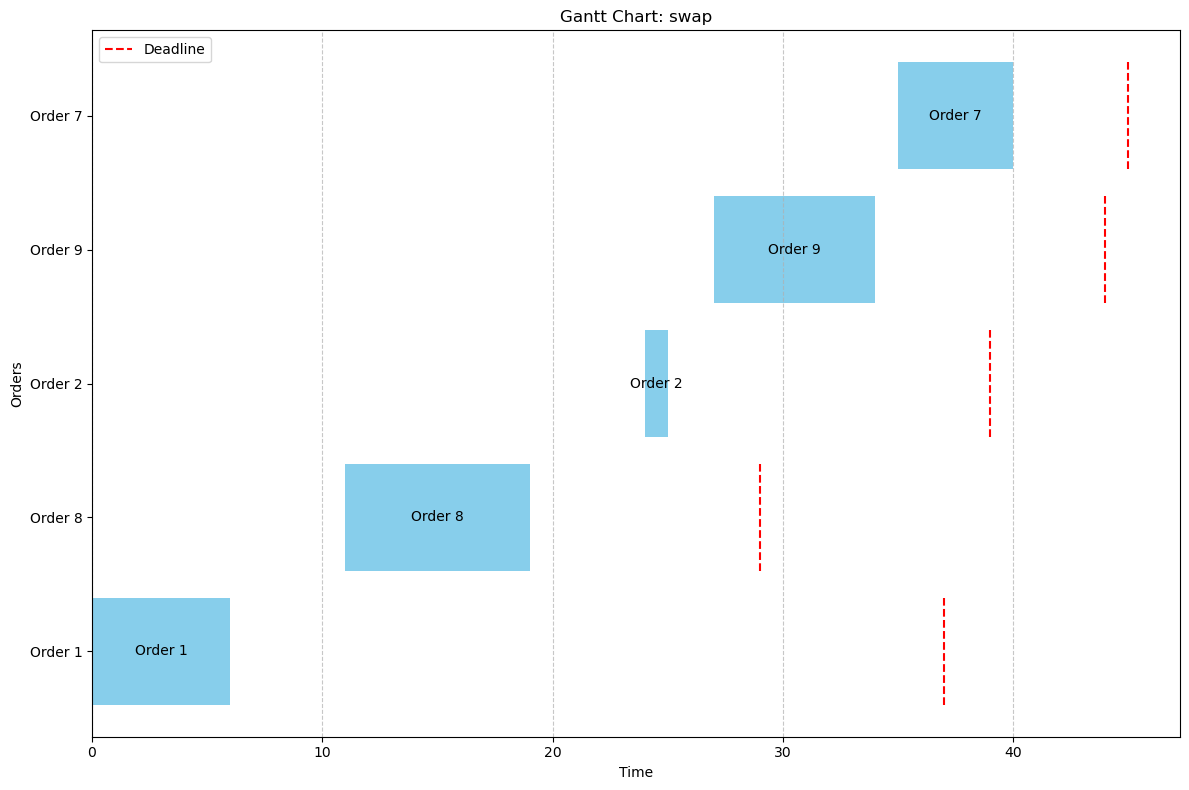

Results for OAS1.txt using swap:
Scheduled Orders: [1, 8, 2, 9, 7]
Total Profit: 292.428574
Run Time: 0.0030 seconds
--------------------------------------------------


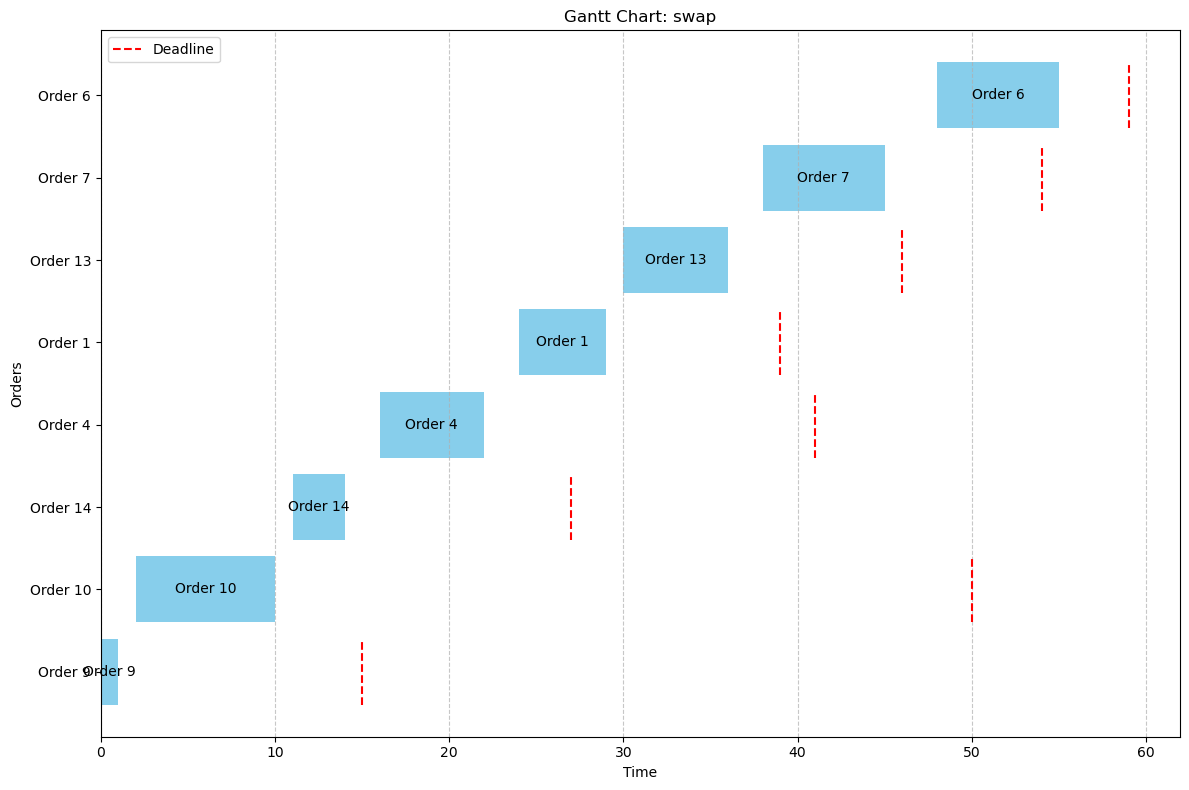

Results for OAS2.txt using swap:
Scheduled Orders: [9, 10, 14, 4, 1, 13, 7, 6]
Total Profit: 294.822964
Run Time: 0.0064 seconds
--------------------------------------------------


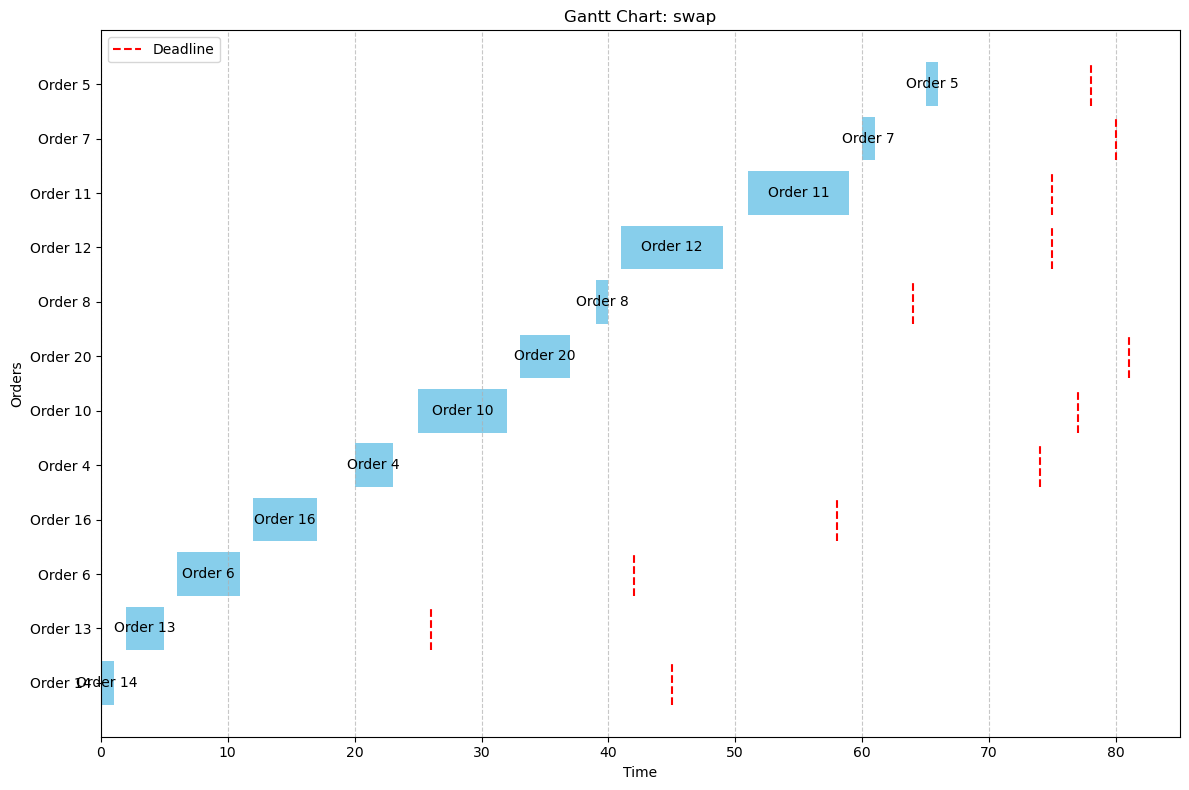

Results for OAS3.txt using swap:
Scheduled Orders: [14, 13, 6, 16, 4, 10, 20, 8, 12, 11, 7, 5]
Total Profit: 620.682186
Run Time: 0.0409 seconds
--------------------------------------------------


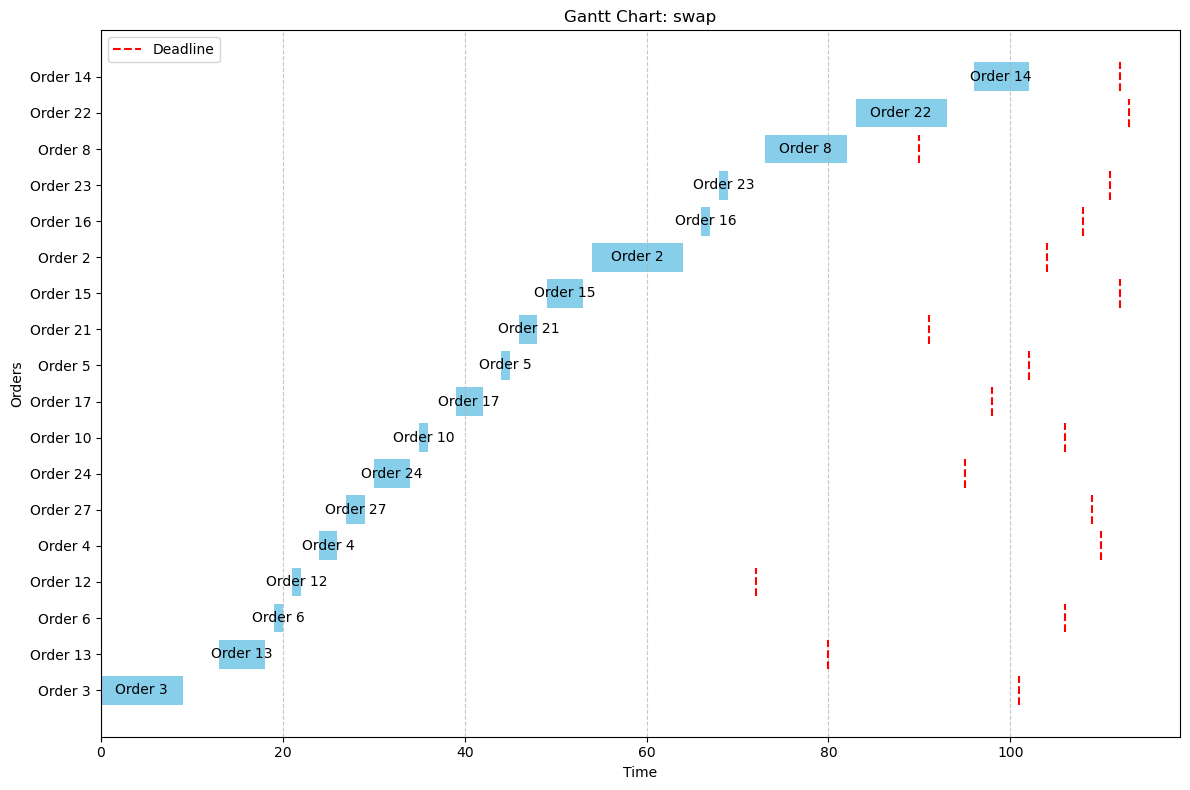

Results for OAS4.txt using swap:
Scheduled Orders: [3, 13, 6, 12, 4, 27, 24, 10, 17, 5, 21, 15, 2, 16, 23, 8, 22, 14]
Total Profit: 909
Run Time: 0.0299 seconds
--------------------------------------------------


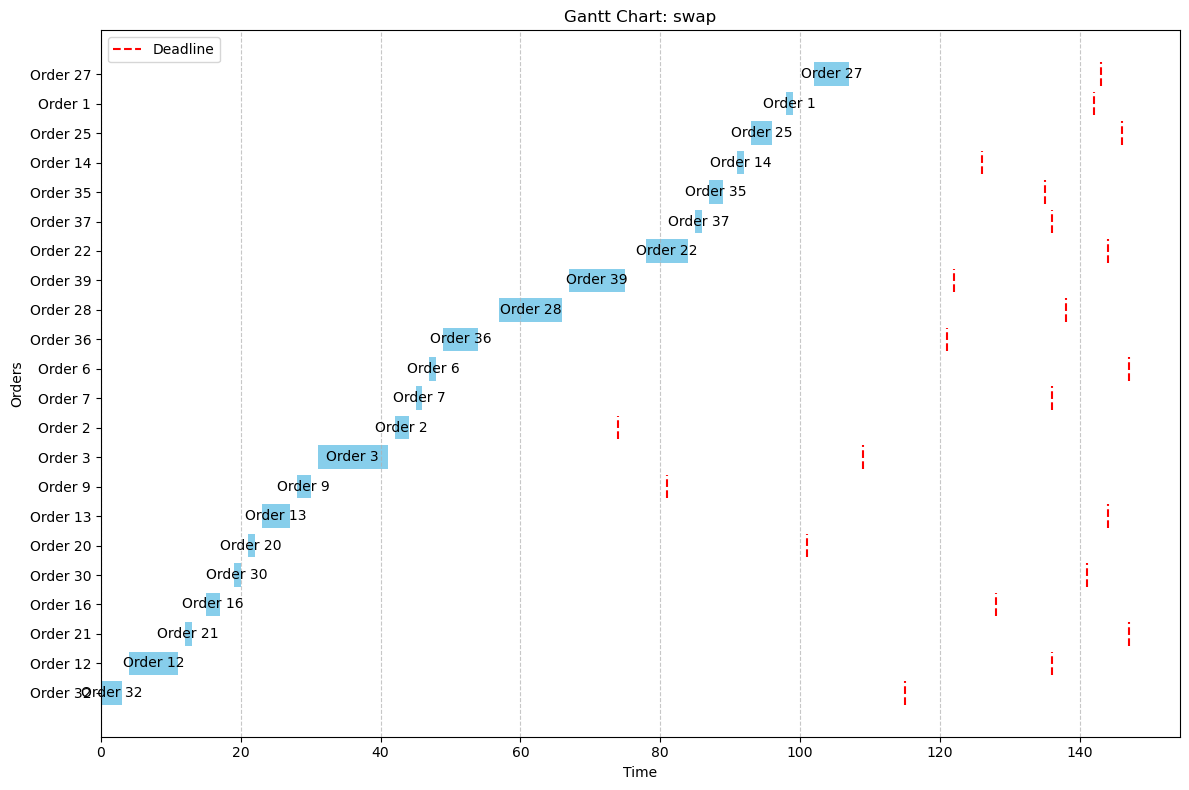

Results for OAS5.txt using swap:
Scheduled Orders: [32, 12, 21, 16, 30, 20, 13, 9, 3, 2, 7, 6, 36, 28, 39, 22, 37, 35, 14, 25, 1, 27]
Total Profit: 1241
Run Time: 0.1147 seconds
--------------------------------------------------


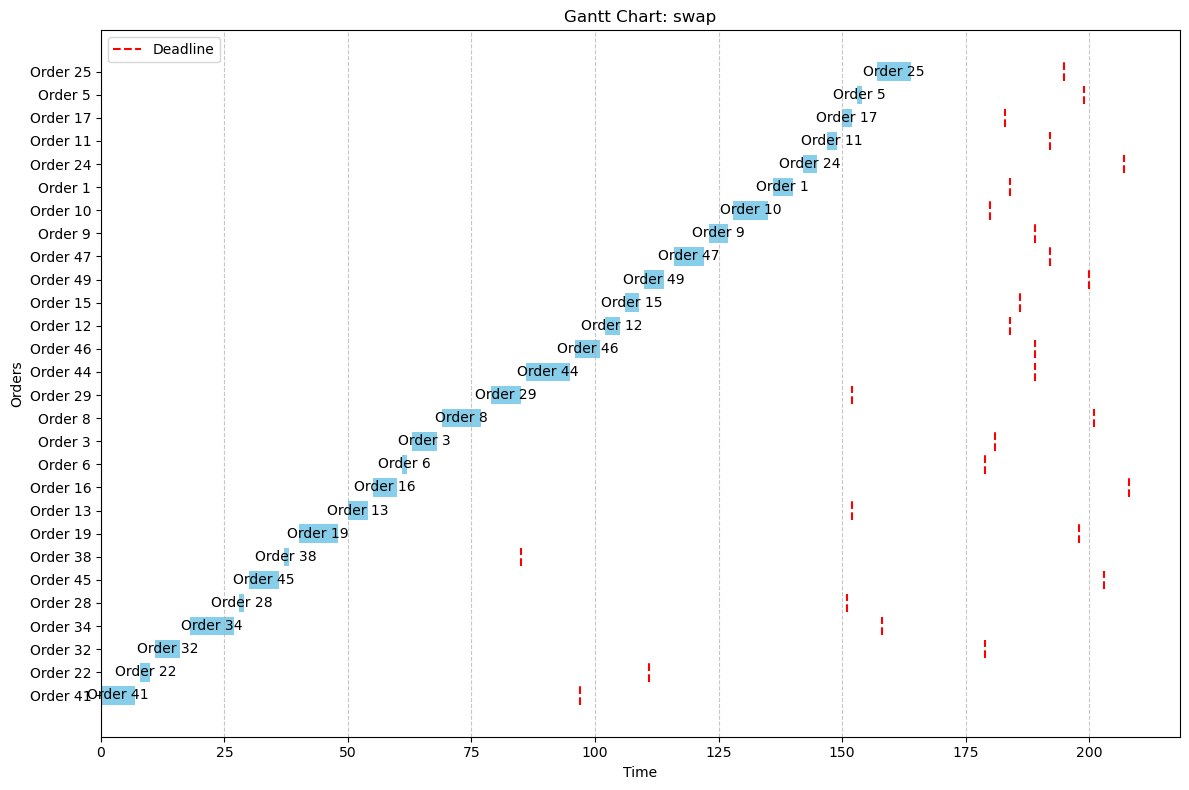

Results for OAS6.txt using swap:
Scheduled Orders: [41, 22, 32, 34, 28, 45, 38, 19, 13, 16, 6, 3, 8, 29, 44, 46, 12, 15, 49, 47, 9, 10, 1, 24, 11, 17, 5, 25]
Total Profit: 1740
Run Time: 1.1200 seconds
--------------------------------------------------


In [21]:
for file_name in file_names:
    Run_and_visualize_improved(file_name, swap, "swap")

#### **5.3 Improve()**

- ***Code :***

In [22]:
def improve(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders, max_iterations=100):
    """
    Local search improvement heuristic using Reverse, Swap, and Move heuristics.
    """
    def calculate_profit(sequence):
        try:
            start_times, _ = cal(duration, setup, sequence)
            return eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence)
        except Exception:
            return None

    def reverse_heuristic(solution):
        """Applies the Reverse heuristic."""
        best_solution = solution
        best_profit = calculate_profit(solution)

        for i in range(len(solution) - 1):
            for j in range(i + 1, len(solution)):
                # Reverse the order of orders between i and j
                new_solution = solution[:i] + solution[i:j + 1][::-1] + solution[j + 1:]
                new_profit = calculate_profit(new_solution)
                if new_profit is not None and new_profit > best_profit:
                    best_solution = new_solution
                    best_profit = new_profit

        return best_solution, best_profit

    # Initialize with the initial solution
    current_solution = initial_solution[:]

    best_solution = current_solution
    best_profit = calculate_profit(current_solution)

    iteration = 0
    while iteration < max_iterations:
        iteration += 1
        improved = False

        # Apply Reverse heuristic
        new_solution, new_profit = reverse_heuristic(current_solution)
        if new_profit > best_profit:
            best_solution = new_solution
            best_profit = new_profit
            improved = True

        # Apply Swap heuristic
        new_solution, new_profit = swap(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
        if new_profit > best_profit:
            best_solution = new_solution
            best_profit = new_profit
            improved = True

        # Apply Move best_accept heuristic
        moved_solution, moved_profit = move_best_accept(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
        if moved_profit > best_profit:
            best_solution = moved_solution
            best_profit = moved_profit
            improved = True
        
         # Apply Move First-accept heuristic
        moved_solution, moved_profit = move(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
        if moved_profit > best_profit:
            best_solution = moved_solution
            best_profit = moved_profit
            improved = True

        if not improved:
            break

        current_solution = best_solution

    return best_solution, best_profit



- ***Visualize :***

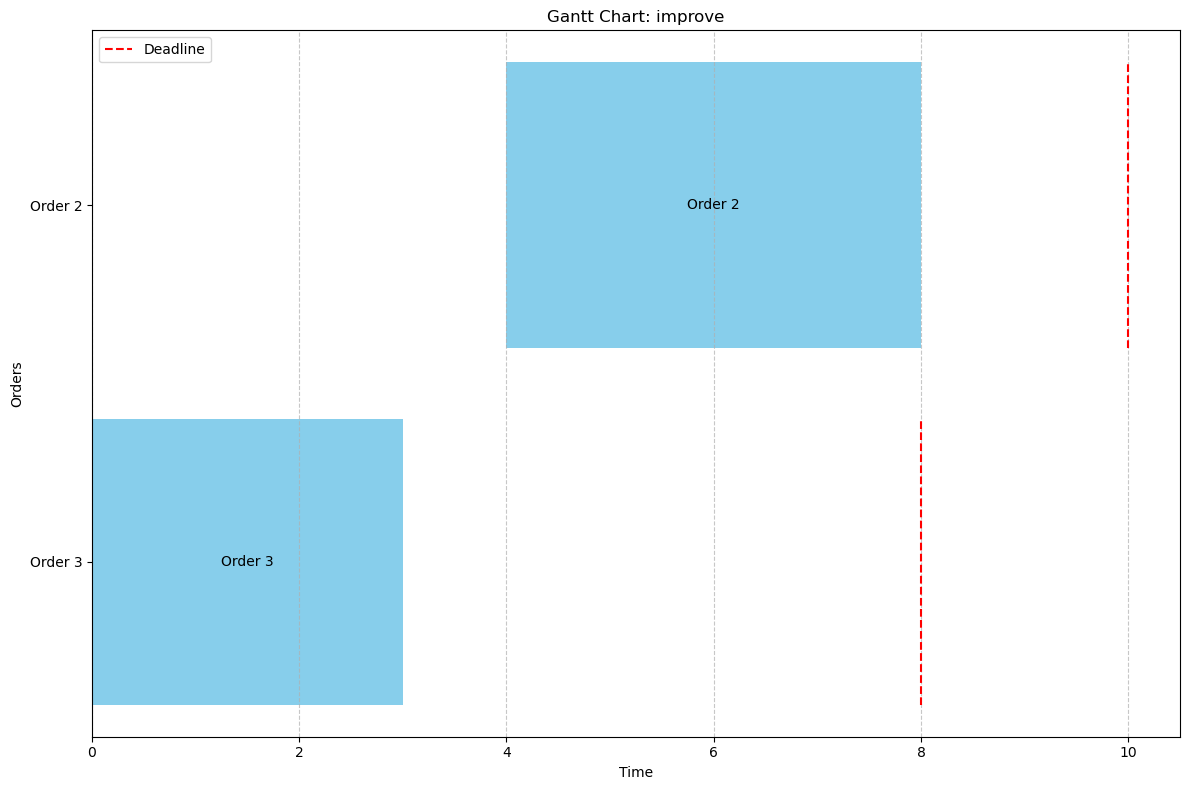

Results for OAS0.txt using improve:
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0030 seconds
--------------------------------------------------


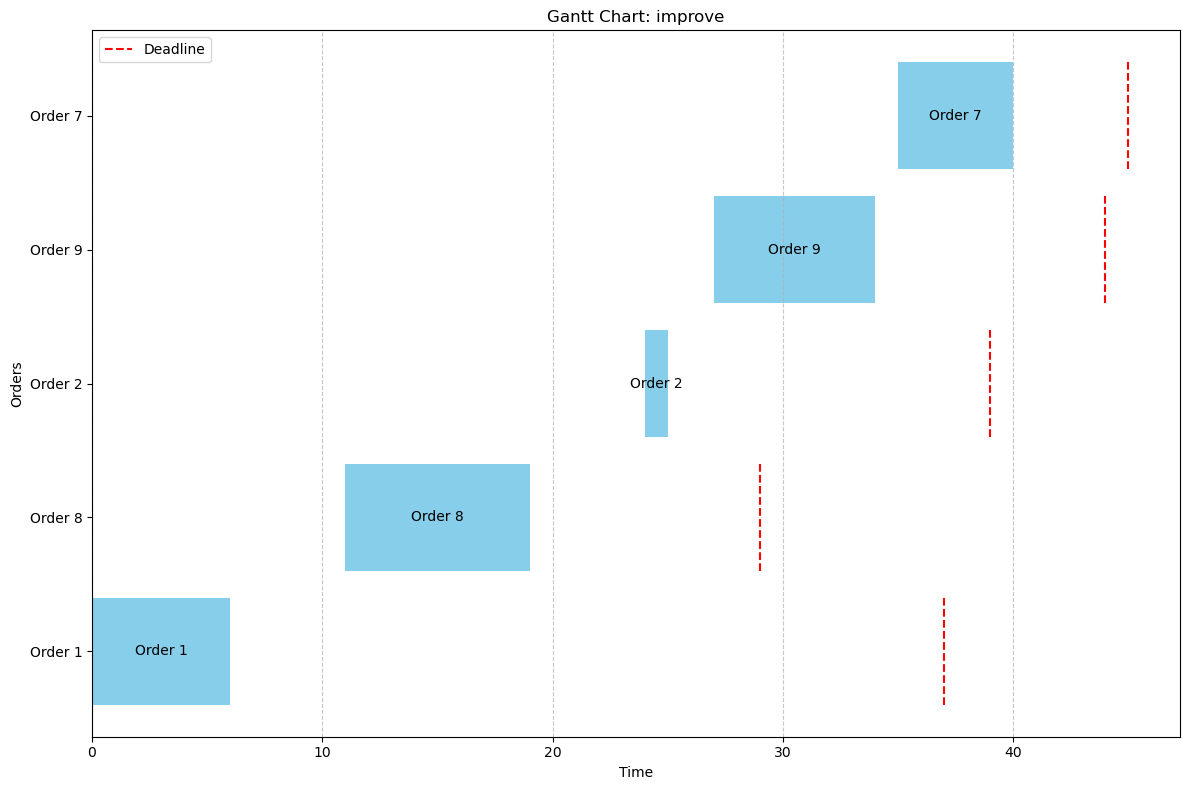

Results for OAS1.txt using improve:
Scheduled Orders: [1, 8, 2, 9, 7]
Total Profit: 292.428574
Run Time: 0.0628 seconds
--------------------------------------------------


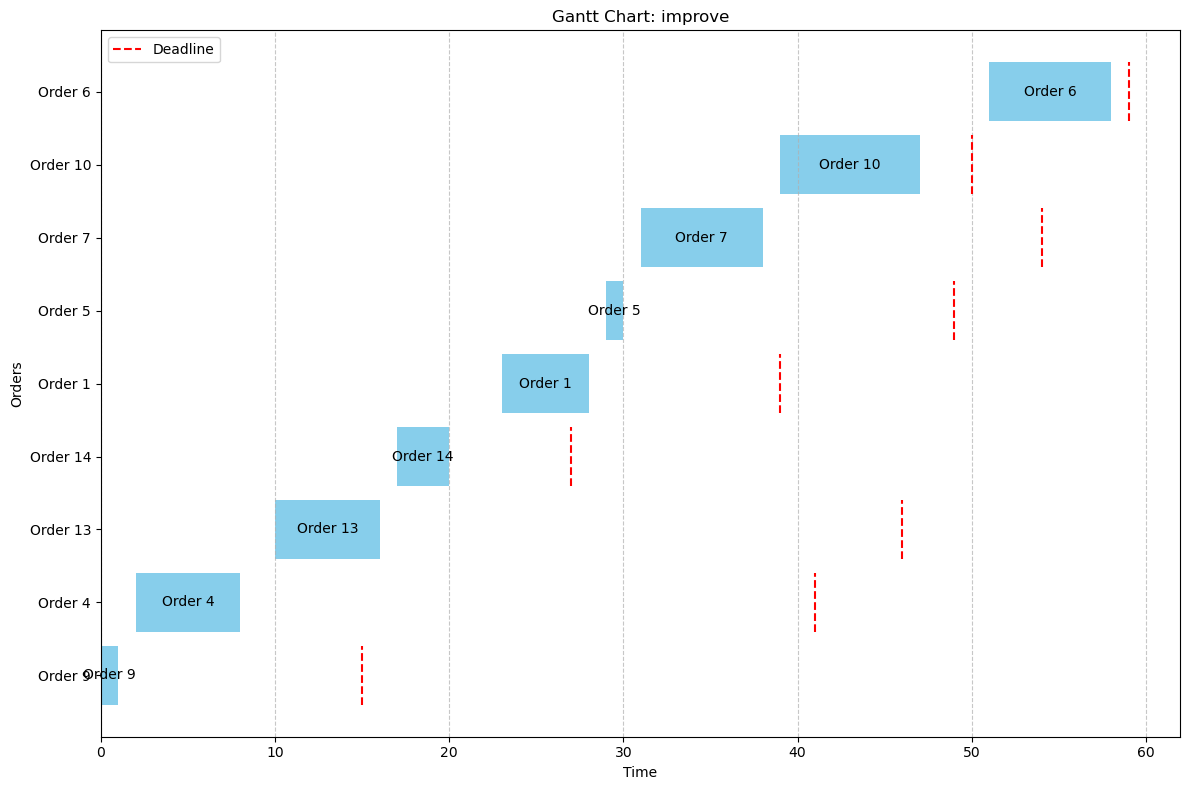

Results for OAS2.txt using improve:
Scheduled Orders: [9, 4, 13, 14, 1, 5, 7, 10, 6]
Total Profit: 297.748551
Run Time: 0.1256 seconds
--------------------------------------------------


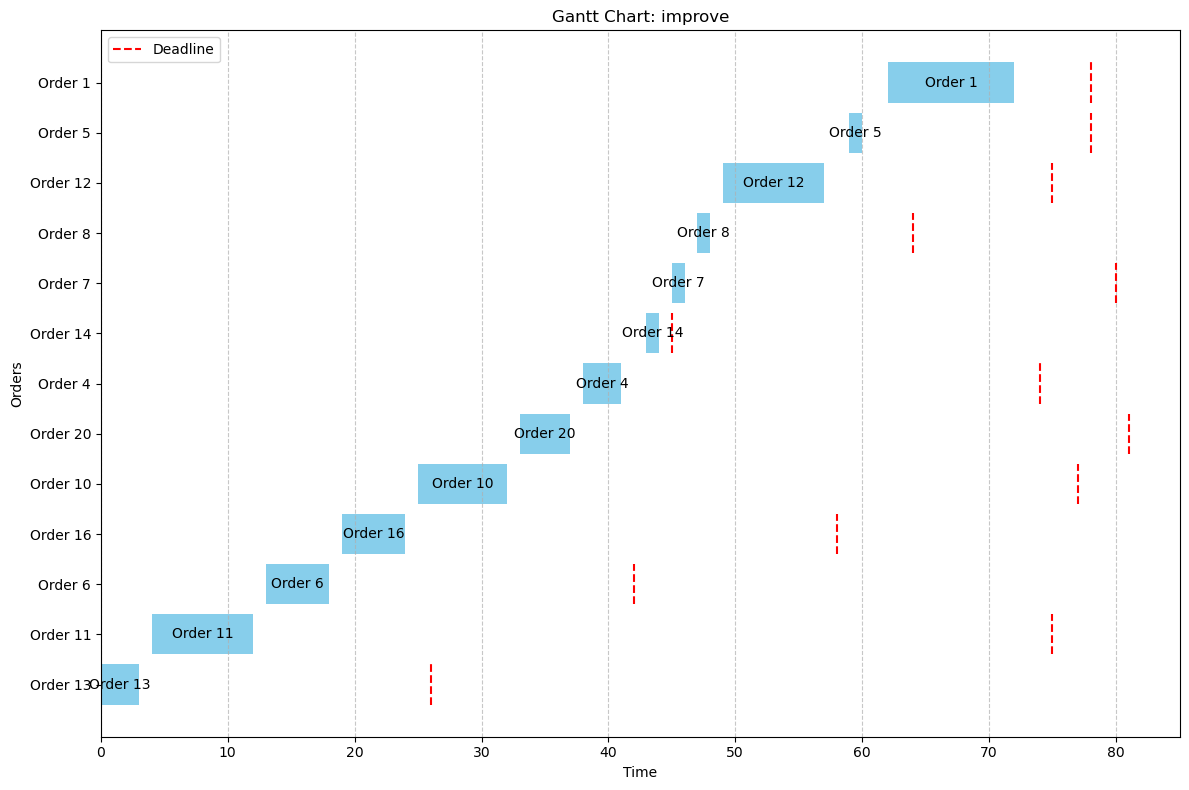

Results for OAS3.txt using improve:
Scheduled Orders: [13, 11, 6, 16, 10, 20, 4, 14, 7, 8, 12, 5, 1]
Total Profit: 760.872484
Run Time: 1.0383 seconds
--------------------------------------------------


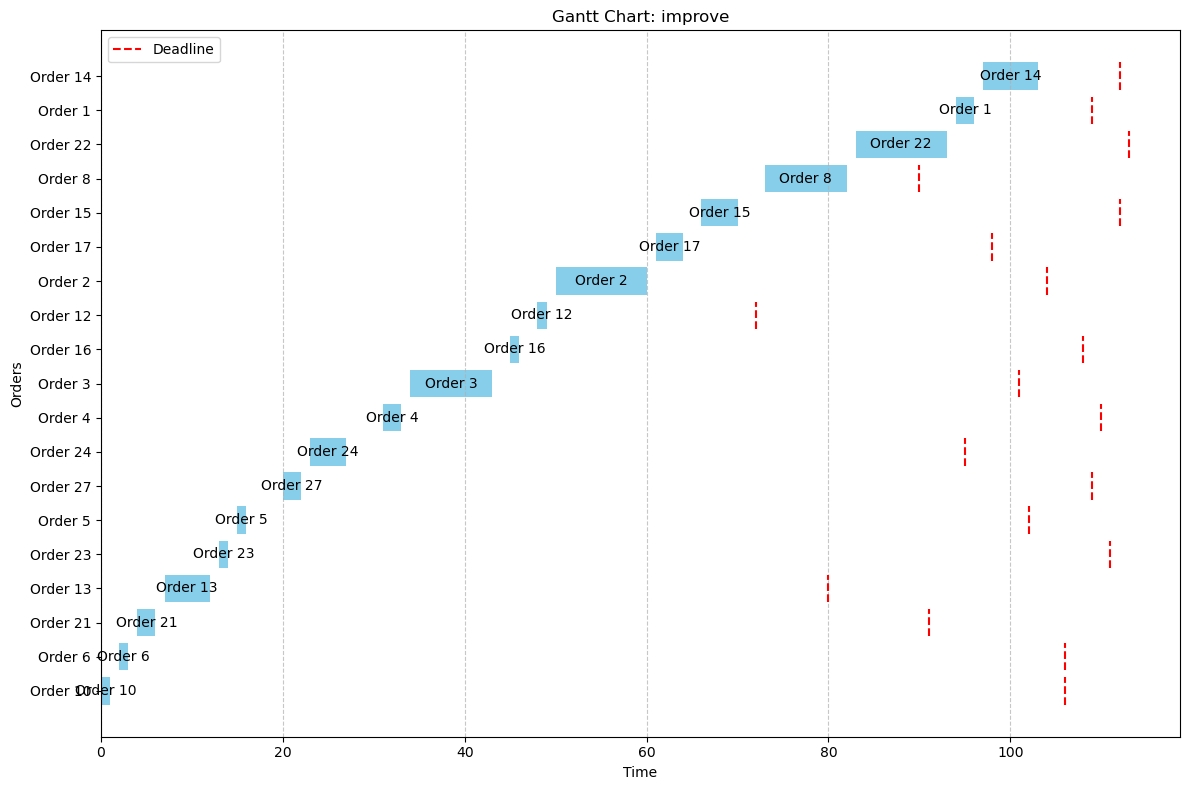

Results for OAS4.txt using improve:
Scheduled Orders: [10, 6, 21, 13, 23, 5, 27, 24, 4, 3, 16, 12, 2, 17, 15, 8, 22, 1, 14]
Total Profit: 910
Run Time: 0.8528 seconds
--------------------------------------------------


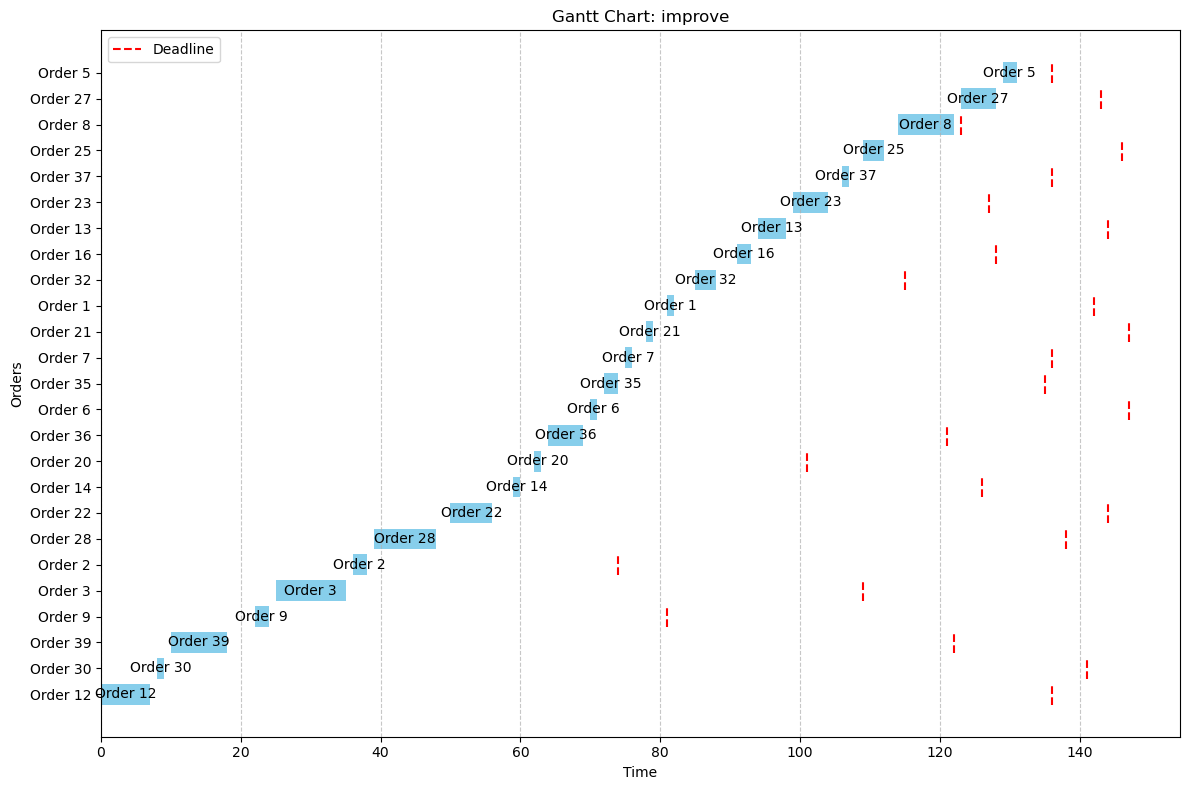

Results for OAS5.txt using improve:
Scheduled Orders: [12, 30, 39, 9, 3, 2, 28, 22, 14, 20, 36, 6, 35, 7, 21, 1, 32, 16, 13, 23, 37, 25, 8, 27, 5]
Total Profit: 1284
Run Time: 4.0756 seconds
--------------------------------------------------


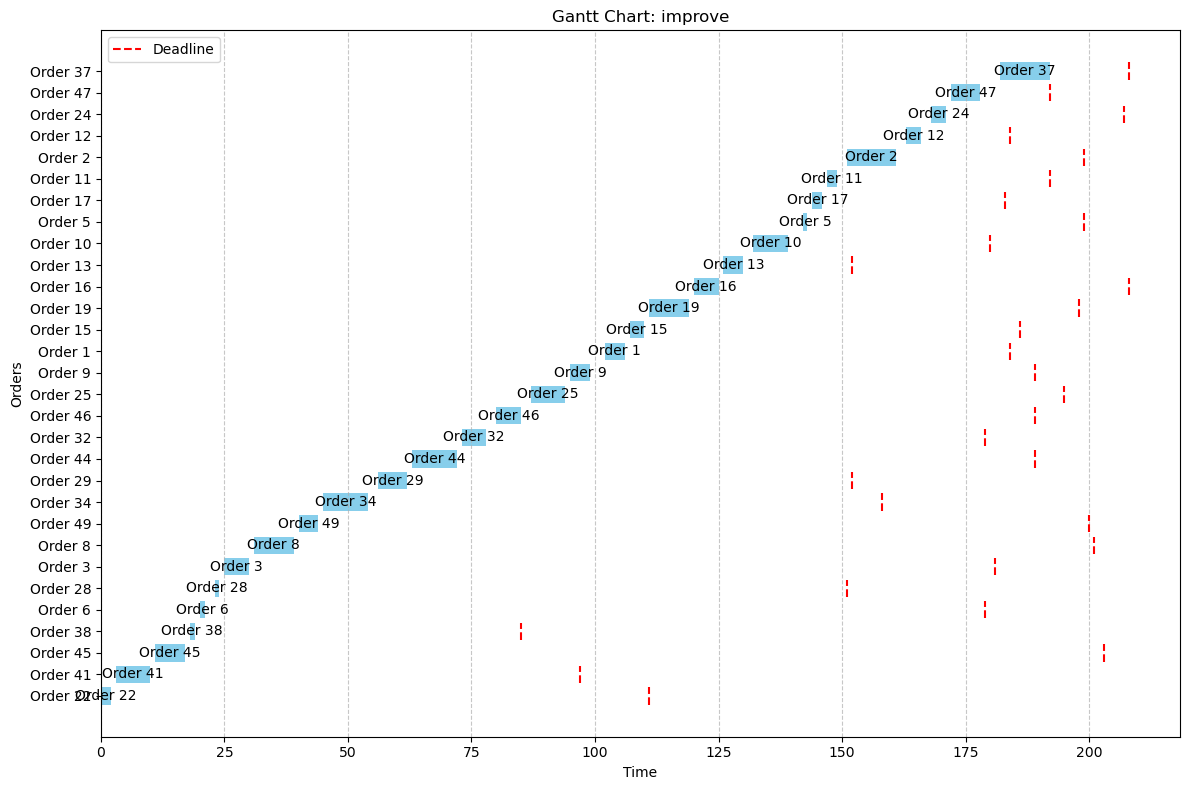

Results for OAS6.txt using improve:
Scheduled Orders: [22, 41, 45, 38, 6, 28, 3, 8, 49, 34, 29, 44, 32, 46, 25, 9, 1, 15, 19, 16, 13, 10, 5, 17, 11, 2, 12, 24, 47, 37]
Total Profit: 1798
Run Time: 4.0378 seconds
--------------------------------------------------


In [23]:
for file_name in file_names:
    Run_and_visualize_improved(file_name, improve, "improve")

### 6. Performance Analysis

#### 6.1 Exact Solutions runtimes

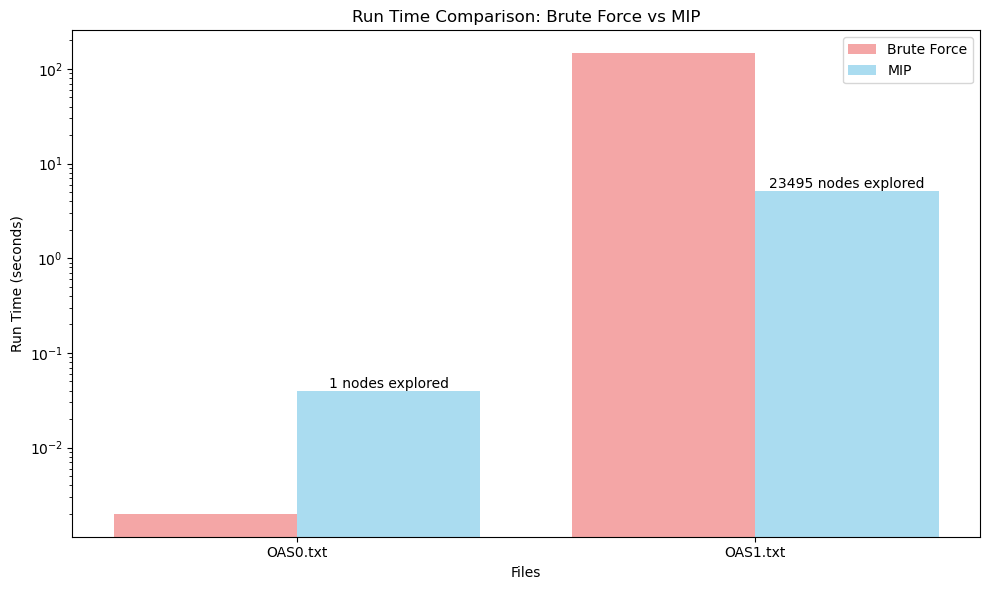

In [24]:
import matplotlib.pyplot as plt

# Runtime data 
file_names = ["OAS0.txt", "OAS1.txt"]
brute_force_times = [0.0020, 145.8849]  
mip_times = [0.04, 5.13]  

# Nodes explored for MIP           
mip_nodes_explored = [1, 23495]        

plt.figure(figsize=(10, 6))
x = range(len(file_names))

plt.bar(x, brute_force_times, width=0.4, label='Brute Force', color='lightcoral', alpha=0.7)
plt.bar([i + 0.4 for i in x], mip_times, width=0.4, label='MIP', color='skyblue', alpha=0.7)

plt.xticks([i + 0.2 for i in x], file_names)
plt.ylabel("Run Time (seconds)")
plt.xlabel("Files")
plt.title("Run Time Comparison: Brute Force vs MIP")
plt.yscale("log")  # logarithmic scale for y-axis
plt.legend()

for i, nodes in enumerate(mip_nodes_explored):
    plt.text(i + 0.4, mip_times[i], f'{nodes} nodes explored', ha='center', va='bottom', fontsize=10, color='black')

# Show the plot
plt.tight_layout()
plt.show()


#### 6.2 Greedy heuristic Accuracy

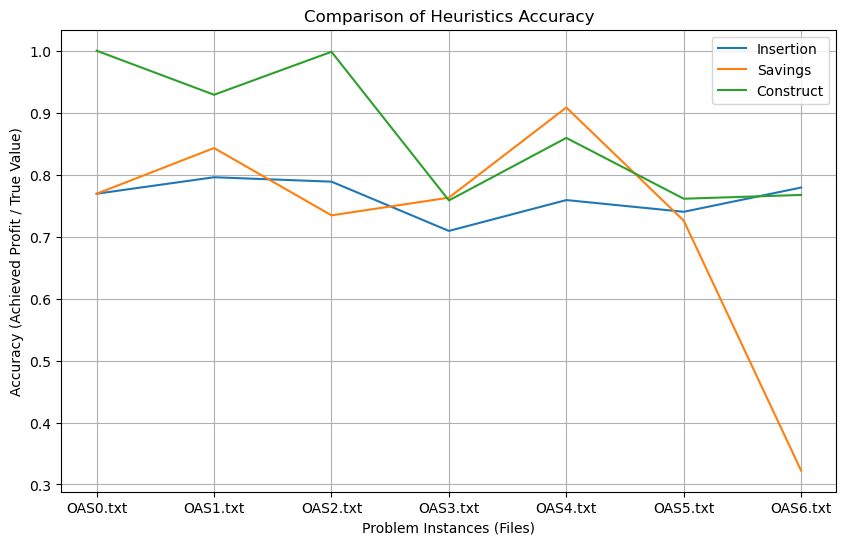

In [46]:
import matplotlib.pyplot as plt

file_names = ['OAS0.txt', 'OAS1.txt', 'OAS2.txt', 'OAS3.txt', 'OAS4.txt', 'OAS5.txt', 'OAS6.txt']
true_values = [13, 382, 478, 894, 1004, 1458, 2002]  # Provided true values
heuristics = ['Insertion', 'Savings', 'Construct']

# Placeholder for accuracies
accuracies = {heuristic: [] for heuristic in heuristics}

for file_name in file_names:
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)
    
    # Assuming construct(), savings(), insertion() functions are defined elsewhere
    schedule1, profit1 = insertion(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)
    schedule2, profit2 = savings(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)
    schedule3, profit3 = construct(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)
    
    accuracies['Insertion'].append(profit1 / true_values[file_names.index(file_name)])
    accuracies['Savings'].append(profit2 / true_values[file_names.index(file_name)])
    accuracies['Construct'].append(profit3 / true_values[file_names.index(file_name)])

# Plotting
plt.figure(figsize=(10, 6))
for heuristic in heuristics:
    plt.plot(file_names, accuracies[heuristic], label=heuristic)

plt.xlabel('Problem Instances (Files)')
plt.ylabel('Accuracy (Achieved Profit / True Value)')
plt.title('Comparison of Heuristics Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#### 6.3 heuristic runtimes

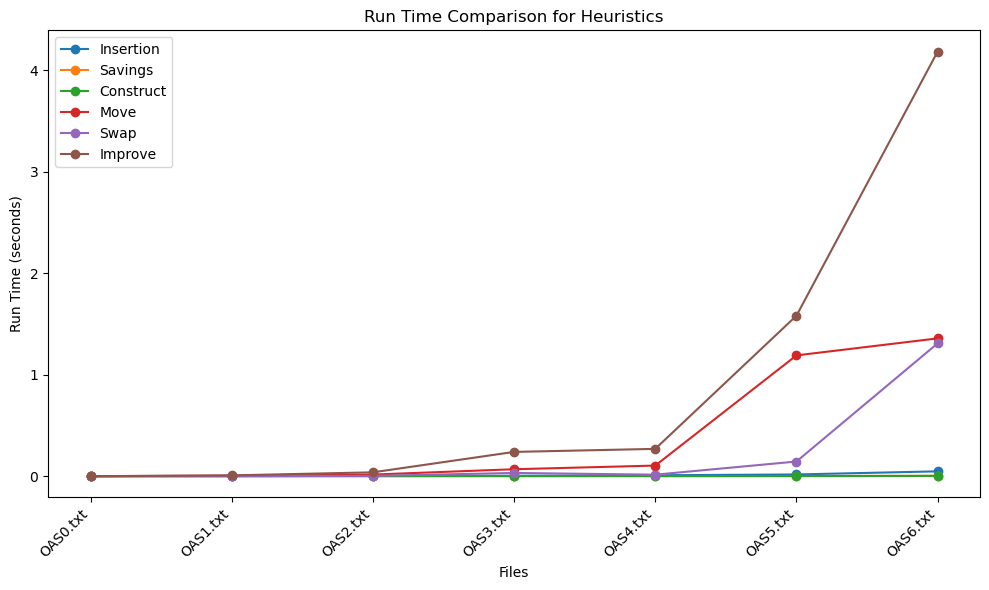

In [27]:
import matplotlib.pyplot as plt
import time
    
heuristics = ['Insertion', 'Savings', 'Construct', 'Move', 'Swap', 'Improve']
run_times = {heuristic: [] for heuristic in heuristics}

file_names = ['OAS0.txt', 'OAS1.txt', 'OAS2.txt', 'OAS3.txt', 'OAS4.txt', 'OAS5.txt', 'OAS6.txt']

for file_name in file_names:
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)

    # Insertion
    start_time = time.time()
    scheduled_orders, total_profit = insertion(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)
    end_time = time.time()
    run_times['Insertion'].append(end_time - start_time)

    # Savings
    start_time = time.time()
    scheduled_orders, total_profit = savings(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)
    end_time = time.time()
    run_times['Savings'].append(end_time - start_time)

    # Construct
    start_time = time.time()
    initial_solution, _ = construct(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)
    end_time = time.time()
    run_times['Construct'].append(end_time - start_time)

    # Move
    start_time = time.time()
    scheduled_orders, improved_profit = move(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
    end_time = time.time()
    run_times['Move'].append(end_time - start_time)

    # Swap
    start_time = time.time()
    scheduled_orders, improved_profit = swap(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
    end_time = time.time()
    run_times['Swap'].append(end_time - start_time)

    # Improve
    start_time = time.time()
    improved_solution, optimal_profit = improve(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders, max_iterations=1)
    end_time = time.time()
    run_times['Improve'].append(end_time - start_time)

plt.figure(figsize=(10, 6))

for heuristic in heuristics:
    plt.plot(file_names, run_times[heuristic], marker='o', label=heuristic)

plt.xlabel('Files')
plt.ylabel('Run Time (seconds)')
plt.title('Run Time Comparison for Heuristics')

plt.legend()

plt.xticks(rotation=45, ha="right") 
plt.tight_layout()
plt.show()


#### 6.4 Profit Comparison

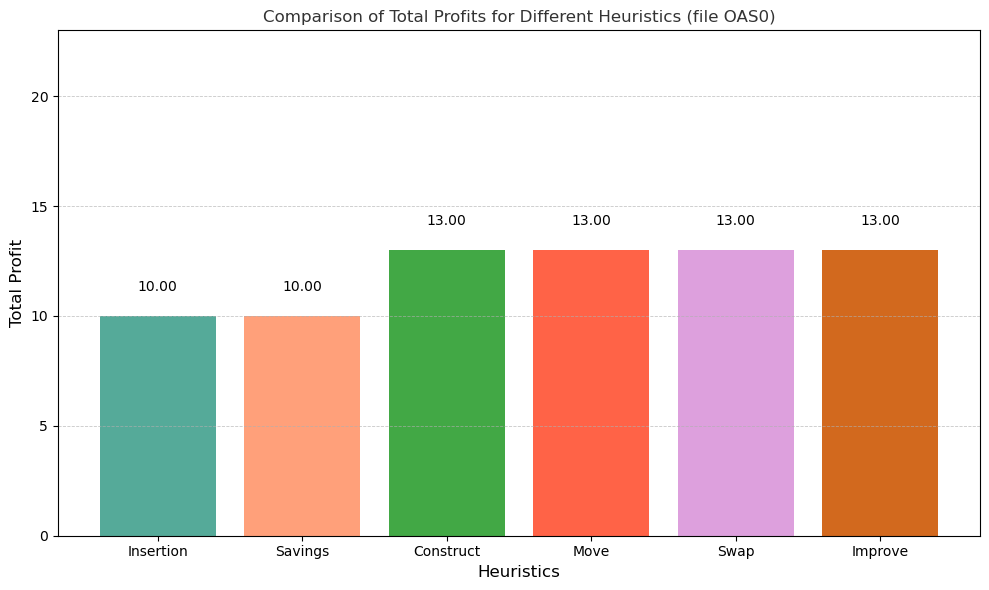

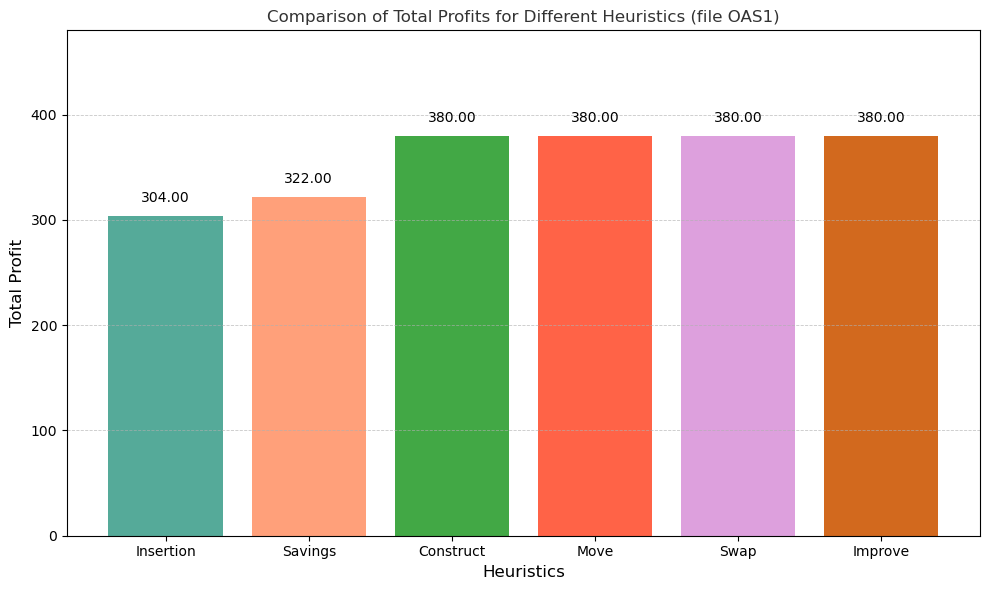

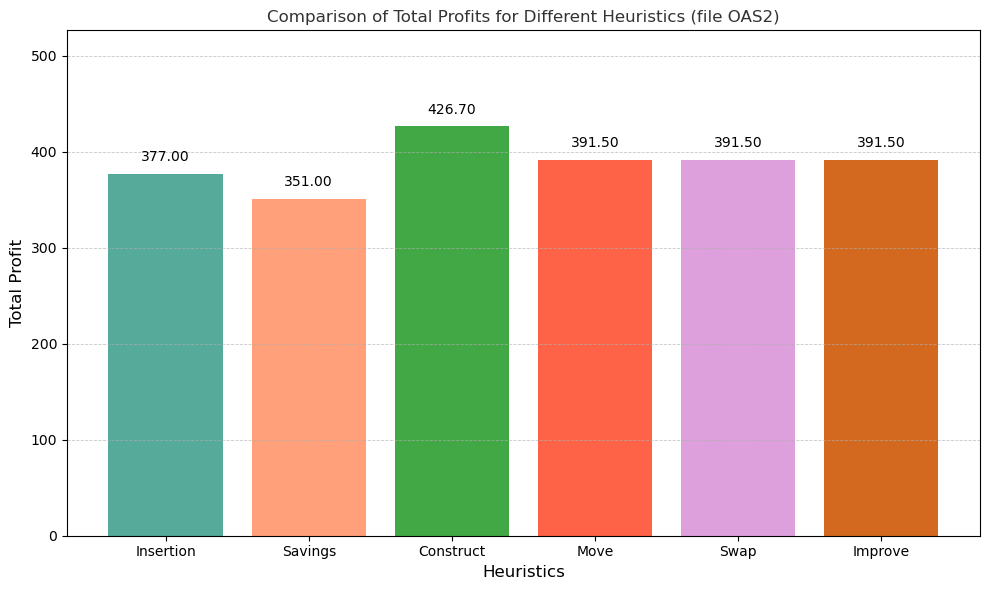

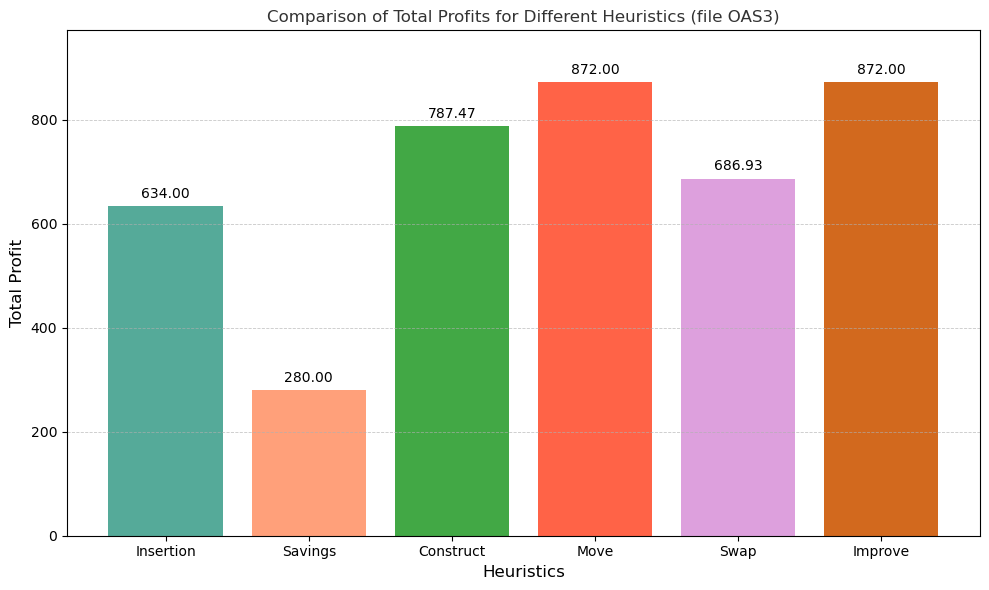

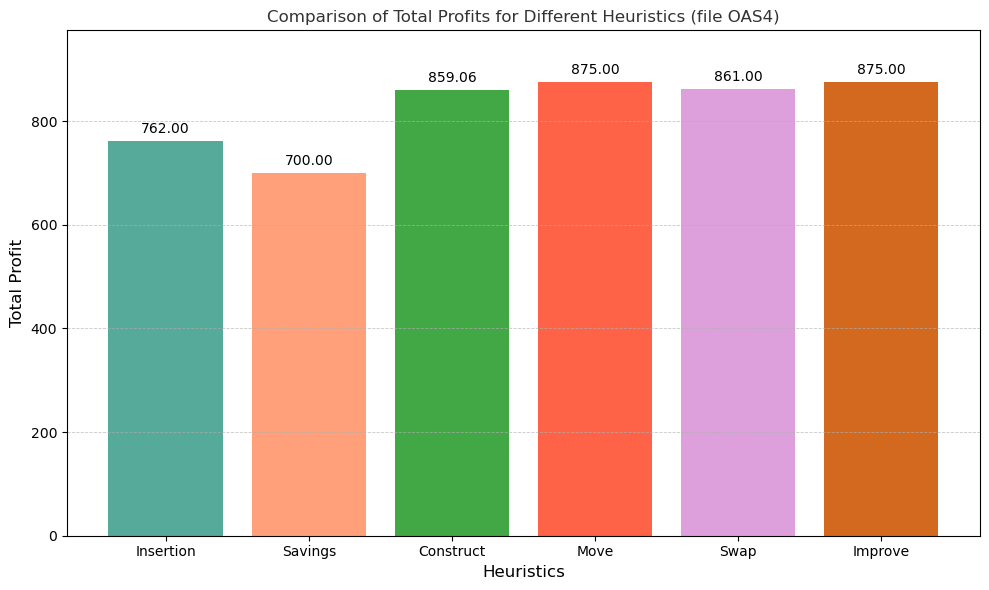

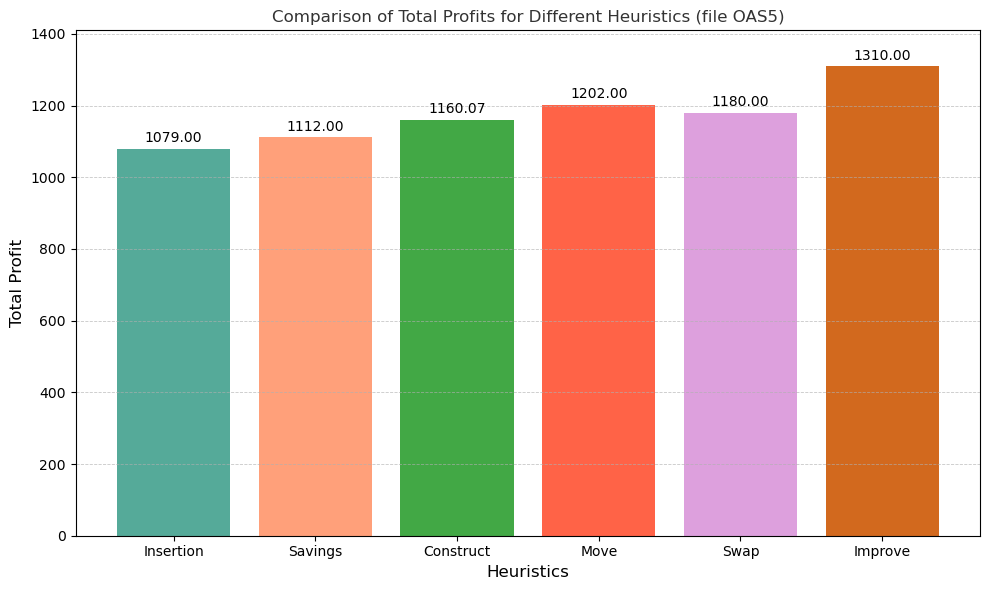

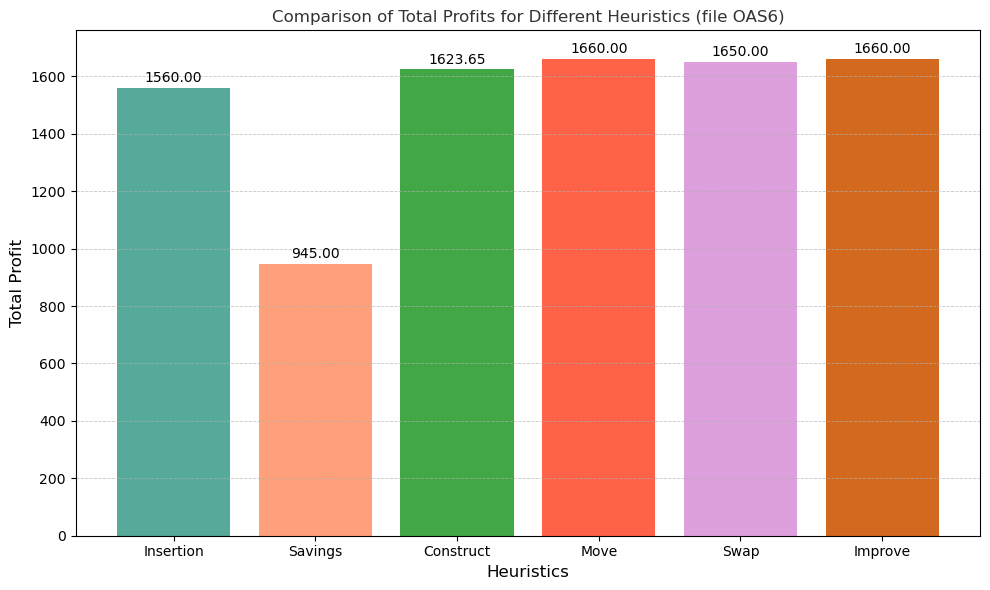

In [26]:
heuristics = ["Insertion", "Savings", "Construct", "Move", "Swap", "Improve"]
total_profits_list = [
    np.array([10, 10, 13, 13, 13, 13], dtype=np.float32),
    np.array([304, 322, 380, 380, 380, 380], dtype=np.float32),
    np.array([377, 351, 426.703297, 391.500002, 391.500002, 391.500002], dtype=np.float32),
    np.array([634, 280, 787.466679, 872, 686.933348, 872], dtype=np.float32),
    np.array([762, 700, 859.055555, 875, 861, 875], dtype=np.float32),
    np.array([1079, 1112, 1160.074094, 1202, 1180, 1310], dtype=np.float32),
    np.array([1560, 945, 1623.649228, 1660, 1650, 1660], dtype=np.float32)
]

colors = ["#5A9", "#FFA07A", "#42A845", "#FF6347", "#DDA0DD", "#D2691E"]

def plot_profit_comparison(heuristics, total_profits, title):
    plt.figure(figsize=(10, 6))

    plt.bar(heuristics, total_profits, color=colors)

    plt.xlabel("Heuristics", fontsize=12)
    plt.ylabel("Total Profit", fontsize=12)
    plt.title(title, fontsize=12, color='#333333')
    plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.7)

    max_profit = max(total_profits)
    plt.ylim(0, max_profit + 100) 

    # Set unique y-axis limit for file 0
    if title == "Comparison of Total Profits for Different Heuristics (file OAS0)":
        plt.ylim(0, max_profit + 10) 

    for i, profit in enumerate(total_profits):
        if title == "Comparison of Total Profits for Different Heuristics (file OAS0)":
            plt.text(i, profit + 1, f"{profit:.2f}", ha="center", va="bottom", fontsize=10)
        else:
            plt.text(i, profit + 10, f"{profit:.2f}", ha="center", va="bottom", fontsize=10)

    plt.tight_layout()

    plt.show()

titles = [
    "Comparison of Total Profits for Different Heuristics (file OAS0)",
    "Comparison of Total Profits for Different Heuristics (file OAS1)",
    "Comparison of Total Profits for Different Heuristics (file OAS2)",
    "Comparison of Total Profits for Different Heuristics (file OAS3)",
    "Comparison of Total Profits for Different Heuristics (file OAS4)",
    "Comparison of Total Profits for Different Heuristics (file OAS5)",
    "Comparison of Total Profits for Different Heuristics (file OAS6)"
]

for i in range(7):
    plot_profit_comparison(heuristics, total_profits_list[i], titles[i])
